In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scp
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
figs_dir = './figs'
subinfo = pd.read_csv(os.path.join(study_dir,'DATA','redcap_exports','ChildMovieStudy-Basics_DATA_2025-07-15_1335.csv'),index_col=0)
clipinfo = pd.read_csv(os.path.join(study_dir, 'measures','clips','clipinfo.csv'), index_col=0)

subs = sorted(os.listdir(data_dir))
subs.remove('.DS_Store')
subinfo.index = subinfo.index.astype(str)
print('Sample size analyzed so far: {0}'.format(len(subs)))

Sample size analyzed so far: 58


## Motion analysis  and plots
Notes
* meanFD = average FD across the movie
* pcCens9 = pecent censored if the FD threshold is 0.9mm FD
* pcCens2 = pecent censored if the FD threshold is 0.2mm FD
* each dot is color coded by participant ID (some colors are very similar though)

In [2]:
data = pd.DataFrame()
i=0
for sub in subs:
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_summary.csv'.format(sub)), index_col=0)
    for movie in subdata.index:
        if np.isfinite(subdata.loc[movie, 'meanFD']):
            data.loc[i, 'sub'] = sub
            try:
                data.loc[i, 'age'] = subinfo.loc[sub, 'child_age_realtime']
                data.loc[i, 'sex'] = subinfo.loc[sub, 'c_gender']-1
            except:
                print(sub)
                pass
            data.loc[i, 'movie'] = movie
            data.loc[i, 'human'] = clipinfo.loc[movie,'humans']
            data.loc[i, 'speaking'] = clipinfo.loc[movie,'speaking']
            data.loc[i, 'contained'] = clipinfo.loc[movie,'contained']
            data.loc[i, 'meanFD'] = subdata.loc[movie, 'meanFD']
            data.loc[i, 'grandmeanFD'] = subdata.loc[:, 'meanFD'].mean()
            if data.loc[i, 'grandmeanFD'] >= 0.6:
                data.loc[i, 'motiongroup'] = 'high'
            else:
                data.loc[i, 'motiongroup'] = 'low'
            data.loc[i, 'pcCens9'] = subdata.loc[movie, 'pcent_volscens_0.9']*100
            data.loc[i, 'pcCens2'] = subdata.loc[movie, 'pcent_volscens_0.2']*100
            try:
                data.loc[i, 'interest'] = subdata.loc[movie, 'interest']
                data.loc[i, 'pos_aff'] = subdata.loc[movie, 'pos_aff']
                data.loc[i, 'neg_aff'] = subdata.loc[movie, 'neg_aff']
                data.loc[i, 'aff_intensity'] = subdata.loc[movie, 'aff_intensity']
            except:
                pass
            i=i+1

data = data.sort_values('movie')
data.describe()

age         sex       human    speaking   contained      meanFD  \
count  304.000000  304.000000  304.000000  304.000000  304.000000  304.000000   
mean     5.588816    0.506579    0.476974    0.611842    0.759868    1.053720   
std      1.723074    0.500781    0.500293    0.488134    0.427868    1.318266   
min      3.000000    0.000000    0.000000    0.000000    0.000000    0.076811   
25%      4.000000    0.000000    0.000000    0.000000    1.000000    0.305315   
50%      5.000000    1.000000    0.000000    1.000000    1.000000    0.525474   
75%      7.000000    1.000000    1.000000    1.000000    1.000000    1.287819   
max      8.000000    1.000000    1.000000    1.000000    1.000000    8.792722   

       grandmeanFD     pcCens9     pcCens2    interest     pos_aff  \
count   304.000000  304.000000  304.000000  289.000000  288.000000   
mean      1.053720   16.909292   44.926021    1.961938    0.944444   
std       0.992929   16.674503   25.074796    1.286389    1.080571   
min       0.087382    0.000000    2.873563    0.000000    0.000000   
25%       0.352355    5.105158   24.929949    1.000000    0.000000   
50%       0.616915   10.275894   39.709833    2.000000    1.000000   
75%       1.451319   23.002103   65.374531    3.000000    2.000000   
max       7.958658   74.983005   99.516519    4.000000    4.000000   

          neg_aff  aff_intensity  
count  289.000000     289.000000  
mean     0.311419       0.958478  
std      0.716793       1.009506  
min      0.000000       0.000000  
25%      0.000000       0.000000  
50%      0.000000       1.000000  
75%      0.000000       1.000000  
max      4.000000       4.000000

### Identify high and low motion kids

0.6478022380386501


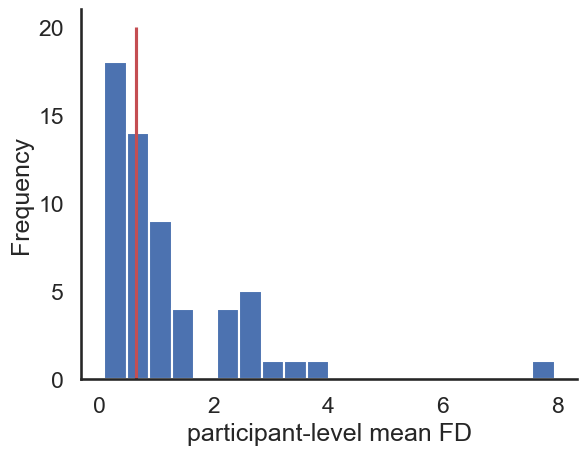

In [3]:
subtempdata = data.loc[:,['sub','age','sex','grandmeanFD']].copy()
subtempdata = subtempdata.drop_duplicates()

subtempdata.loc[:,'grandmeanFD'].plot(kind='hist', bins=20)
plt.vlines(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50), ymin=0, ymax=20, color='r')
print(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50))
sns.despine()
plt.xlabel('participant-level mean FD')
plt.show()
plt.close()

### mixed effects models examining movie and other factors predicting motion

#### Full sample

The below cell has results from a mixed effect model predicting FD from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST motion to MOST after accounting for these features is listed after the model results below.

In [4]:
res = smf.mixedlm('meanFD ~ age + sex', groups='sub', data=data).fit()
data.loc[:, 'meanFD_res'] = res.resid
print(res.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 304     Method:             REML     
No. Groups:       58      Scale:              0.9673   
Min. group size:  1       Log-Likelihood:     -472.5120
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.912    0.444  6.559 0.000  2.042  3.783
age          -0.313    0.072 -4.363 0.000 -0.454 -0.172
sex          -0.114    0.246 -0.465 0.642 -0.597  0.368
sub Var       0.680    0.217                           



In [5]:
# rank means = resid FD
means = pd.DataFrame()
for m in np.unique(data.loc[:,'movie']):
    means.loc[m, 'FD'] = data.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(data.loc[data['movie']==m1,'meanFD_res'], 
                         data.loc[data['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao        one_man_band -0.067869  0.946503
2     bao  sanjays_super_team -0.305916  0.762421
3     bao     partysaurus_rex -0.418885  0.679362
4     bao       mikes_new_car -0.322765  0.749454
5     bao            zootopia -0.442505  0.661784
6     bao       party_central -0.703524  0.487982
7     bao           small_fry -0.899839  0.378409
8     bao       despicable_me -0.734367  0.469558
9     bao             boundin -0.712765  0.482591
10    bao               bluey -0.923023  0.364818
11    bao       partly_cloudy -0.883037  0.385308
12    bao           air_mater -0.835974  0.410787
13    bao            aeronaut -2.029295  0.054155
14    bao               birds -0.976497  0.338559
15    bao                 lou -0.792522  0.435821
16    bao              frozen -2.766076  0.010993
17    bao               piper -2.296399  0.031548
18    bao          inside_out -1.215274  0.235182
19    bao               moana -1.296205  0.207761
20    bao     jackjack_attack -0.929604  0.362665
21    bao             la_luna -1.973270  0.061158

In [6]:
# rank means = raw FD
means = pd.DataFrame()
for m in np.unique(data.loc[:,'movie']):
    means.loc[m, 'FD'] = data.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(data.loc[data['movie']==m1,'meanFD'], 
                         data.loc[data['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao  sanjays_super_team -0.222748  0.825698
2     bao       mikes_new_car -0.184723  0.854879
3     bao        one_man_band -0.261068  0.796469
4     bao            zootopia -0.250169  0.804423
5     bao       party_central -0.366125  0.717234
6     bao     partysaurus_rex -0.463597  0.647490
7     bao           small_fry -0.497110  0.624276
8     bao       partly_cloudy -0.708560  0.484902
9     bao           air_mater -0.620676  0.540216
10    bao             la_luna -0.820991  0.420459
11    bao            aeronaut -1.057300  0.301354
12    bao               piper -0.991768  0.332094
13    bao       despicable_me -1.155464  0.258825
14    bao          inside_out -0.774679  0.445518
15    bao              frozen -1.457068  0.158616
16    bao             boundin -0.858829  0.398595
17    bao     jackjack_attack -0.638337  0.529844
18    bao               bluey -1.156635  0.258355
19    bao               birds -1.097244  0.283422
20    bao                 lou -0.923278  0.365052
21    bao               moana -1.121942  0.273464

In [7]:
# rank means = raw FD
age34 = data.loc[data['age']<5,:]
means = pd.DataFrame()
for m in np.unique(age34.loc[:,'movie']):
    means.loc[m, 'FD'] = age34.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age34.loc[age34['movie']==m1,'meanFD'], 
                         age34.loc[age34['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   zootopia           small_fry -0.004730  0.996358
2   zootopia        one_man_band -0.249693  0.809994
3   zootopia     partysaurus_rex -0.779945  0.460976
4   zootopia             la_luna -1.075505  0.323483
5   zootopia       partly_cloudy -0.869875  0.409709
6   zootopia          inside_out -1.022127  0.336632
7   zootopia                 bao -1.408554  0.208620
8   zootopia  sanjays_super_team -1.274841  0.243048
9   zootopia              frozen -1.263536  0.246849
10  zootopia               bluey -0.932396  0.378413
11  zootopia               piper -1.077098  0.317150
12  zootopia            aeronaut -1.329888  0.225251
13  zootopia                 lou -0.807971  0.442467
14  zootopia       mikes_new_car -0.985509  0.353238
15  zootopia       party_central -1.041634  0.328034
16  zootopia               birds -1.452941  0.184310
17  zootopia       despicable_me -2.804283  0.023045
18  zootopia           air_mater -0.877902  0.405590
19  zootopia             boundin -1.161521  0.278911
20  zootopia               moana -1.547774  0.165603
21  zootopia     jackjack_attack -1.246408  0.259070

In [8]:
# rank means = res FD
age34 = data.loc[data['age']<5,:]
means = pd.DataFrame()
for m in np.unique(age34.loc[:,'movie']):
    means.loc[m, 'FD'] = age34.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age34.loc[age34['movie']==m1,'meanFD_res'], 
                         age34.loc[age34['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   zootopia                 bao -0.198947  0.848875
2   zootopia           small_fry -0.413115  0.691884
3   zootopia        one_man_band -0.812322  0.443351
4   zootopia  sanjays_super_team -0.651633  0.535439
5   zootopia               bluey -0.549052  0.597957
6   zootopia       partly_cloudy -1.051645  0.323688
7   zootopia     partysaurus_rex -1.474864  0.183750
8   zootopia          inside_out -1.895446  0.094629
9   zootopia                 lou -0.744935  0.477622
10  zootopia             la_luna -1.429903  0.202686
11  zootopia               birds -1.023586  0.335983
12  zootopia       despicable_me -1.368379  0.208386
13  zootopia              frozen -2.259247  0.058396
14  zootopia       mikes_new_car -1.479956  0.177153
15  zootopia               piper -1.978268  0.088407
16  zootopia       party_central -1.540046  0.162114
17  zootopia            aeronaut -2.079352  0.076158
18  zootopia           air_mater -1.027634  0.334188
19  zootopia             boundin -1.325988  0.221451
20  zootopia               moana -1.237994  0.255626
21  zootopia     jackjack_attack -1.353863  0.224551

In [9]:
# rank means = raw FD
age56 = data.loc[(data['age']==5) | (data['age']==6),:]
means = pd.DataFrame()
for m in np.unique(age56.loc[:,'movie']):
    means.loc[m, 'FD'] = age56.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age56.loc[age56['movie']==m1,'meanFD'], 
                         age56.loc[age56['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao     jackjack_attack -0.021100  0.983850
2     bao  sanjays_super_team -0.346794  0.740585
3     bao               moana -1.899796  0.106200
4     bao       mikes_new_car -1.008923  0.342550
5     bao               birds -2.040235  0.087416
6     bao           air_mater -1.703699  0.126841
7     bao       partly_cloudy -1.778220  0.113258
8     bao             la_luna -2.652666  0.037893
9     bao       party_central -1.768017  0.115033
10    bao             boundin -1.525818  0.170887
11    bao       despicable_me -1.602303  0.153123
12    bao            zootopia -1.213038  0.259715
13    bao              frozen -2.702955  0.035436
14    bao     partysaurus_rex -2.152848  0.083942
15    bao        one_man_band -2.611193  0.047601
16    bao            aeronaut -2.572161  0.042212
17    bao               bluey -2.074517  0.076704
18    bao               piper -2.112792  0.088309
19    bao          inside_out -1.187791  0.268982
20    bao                 lou -1.135184  0.293668
21    bao           small_fry -2.597047  0.060235

In [10]:
# rank means = res FD
age56 = data.loc[(data['age']==5) | (data['age']==6),:]
means = pd.DataFrame()
for m in np.unique(age56.loc[:,'movie']):
    means.loc[m, 'FD'] = age56.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age56.loc[age56['movie']==m1,'meanFD_res'], 
                         age56.loc[age56['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   mikes_new_car               birds -0.140567  0.891687
2   mikes_new_car             boundin -0.266785  0.795647
3   mikes_new_car                 bao -0.337103  0.744713
4   mikes_new_car     jackjack_attack -0.345269  0.738795
5   mikes_new_car           air_mater -0.499070  0.628526
6   mikes_new_car       partly_cloudy -0.517266  0.616218
7   mikes_new_car     partysaurus_rex -0.321331  0.757341
8   mikes_new_car       party_central -0.551889  0.593143
9   mikes_new_car  sanjays_super_team -0.478585  0.645040
10  mikes_new_car        one_man_band -0.435515  0.676302
11  mikes_new_car               moana -0.816333  0.437940
12  mikes_new_car       despicable_me -0.740868  0.477657
13  mikes_new_car              frozen -1.087873  0.308336
14  mikes_new_car             la_luna -1.533390  0.163722
15  mikes_new_car            aeronaut -1.622908  0.143265
16  mikes_new_car            zootopia -1.474858  0.171025
17  mikes_new_car               bluey -1.699872  0.123372
18  mikes_new_car           small_fry -1.332102  0.231190
19  mikes_new_car               piper -1.661699  0.140528
20  mikes_new_car                 lou -0.961498  0.361421
21  mikes_new_car          inside_out -1.549353  0.152339

In [11]:
# rank means = raw FD
age78 = data.loc[(data['age']==7) | (data['age']==8),:]
means = pd.DataFrame()
for m in np.unique(age78.loc[:,'movie']):
    means.loc[m, 'FD'] = age78.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age78.loc[age78['movie']==m1,'meanFD'], 
                         age78.loc[age78['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   inside_out       party_central -0.655491  0.530546
2   inside_out            zootopia -1.337776  0.217749
3   inside_out       mikes_new_car -1.483066  0.176345
4   inside_out                 lou -3.167350  0.015766
5   inside_out             boundin -3.377686  0.009675
6   inside_out            aeronaut -4.108136  0.003399
7   inside_out        one_man_band -1.776355  0.113580
8   inside_out       despicable_me -3.251224  0.011680
9   inside_out     partysaurus_rex -3.552152  0.007486
10  inside_out               bluey -2.966992  0.017953
11  inside_out               piper -1.263339  0.242040
12  inside_out           small_fry -2.044130  0.075190
13  inside_out           air_mater -1.011954  0.341184
14  inside_out     jackjack_attack -2.042229  0.075413
15  inside_out  sanjays_super_team -1.738172  0.120378
16  inside_out                 bao -1.553146  0.158992
17  inside_out              frozen -2.273011  0.052642
18  inside_out               moana -2.305121  0.050069
19  inside_out       partly_cloudy -1.021660  0.336840
20  inside_out               birds -1.185622  0.269791
21  inside_out             la_luna -1.324637  0.221879

In [12]:
# rank means = res FD
age78 = data.loc[(data['age']==7) | (data['age']==8),:]
means = pd.DataFrame()
for m in np.unique(age78.loc[:,'movie']):
    means.loc[m, 'FD'] = age78.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age78.loc[age78['movie']==m1,'meanFD_res'], 
                         age78.loc[age78['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   inside_out       party_central -0.123947  0.904415
2   inside_out            zootopia -0.199457  0.846881
3   inside_out             boundin -0.205580  0.842254
4   inside_out       despicable_me -0.332111  0.748339
5   inside_out       mikes_new_car -0.471255  0.650043
6   inside_out            aeronaut -0.636590  0.542173
7   inside_out        one_man_band -0.858186  0.415759
8   inside_out     partysaurus_rex -0.983024  0.354387
9   inside_out     jackjack_attack -0.825157  0.433197
10  inside_out               bluey -0.808958  0.441931
11  inside_out                 lou -1.005349  0.348209
12  inside_out  sanjays_super_team -1.283563  0.235223
13  inside_out                 bao -1.319544  0.223498
14  inside_out               piper -1.290992  0.232761
15  inside_out           small_fry -1.787078  0.111737
16  inside_out               moana -1.855472  0.100628
17  inside_out           air_mater -0.945682  0.371994
18  inside_out              frozen -2.572042  0.033023
19  inside_out             la_luna -1.313199  0.225529
20  inside_out       partly_cloudy -1.154706  0.281535
21  inside_out               birds -1.274510  0.238254

### raw data plots - high motion only

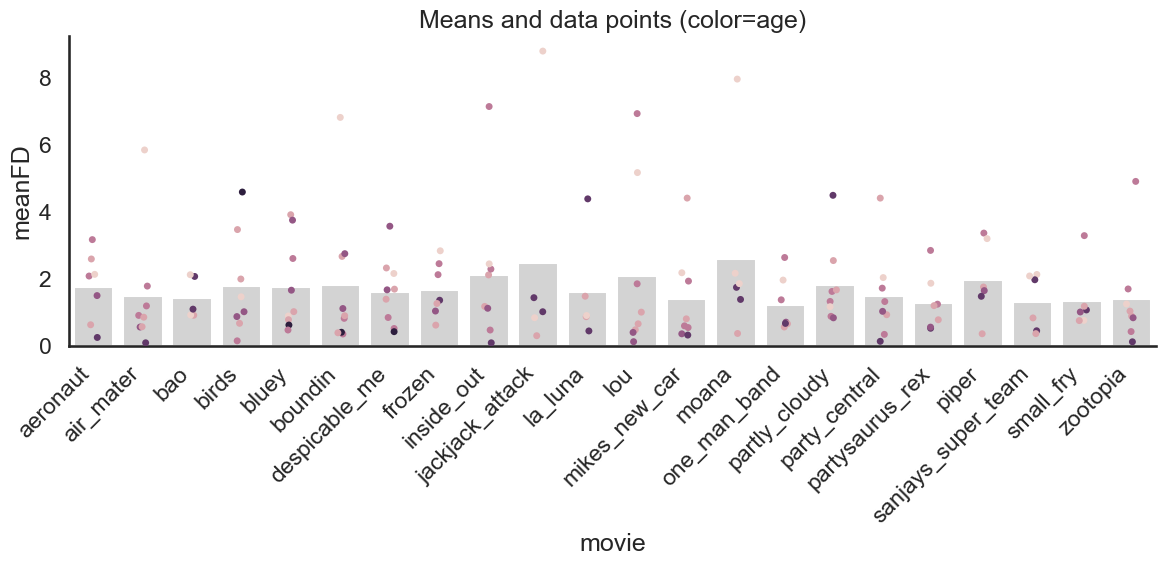

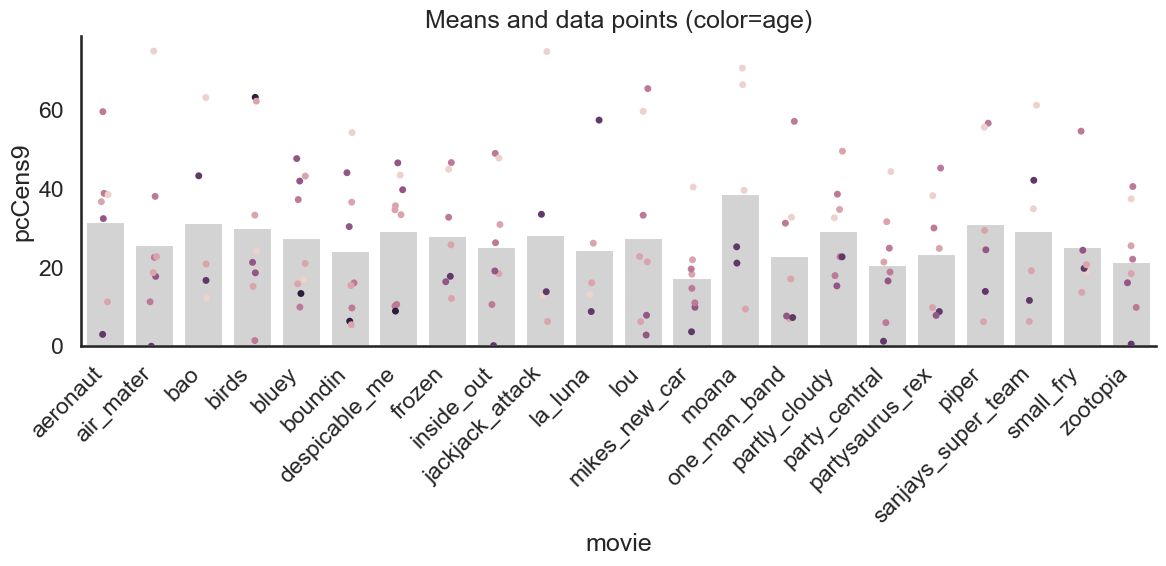

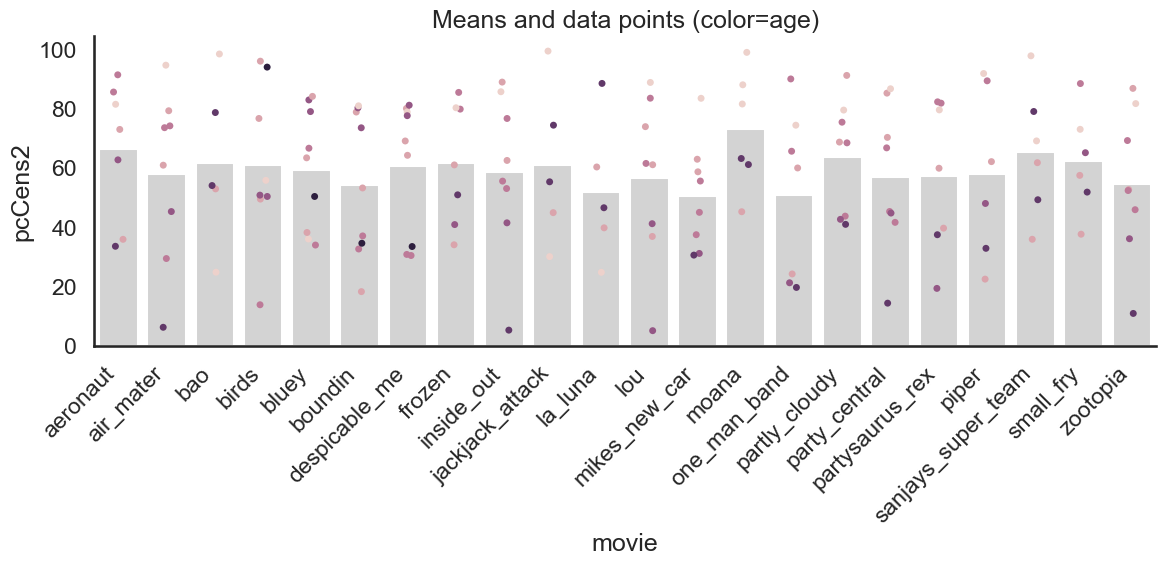

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


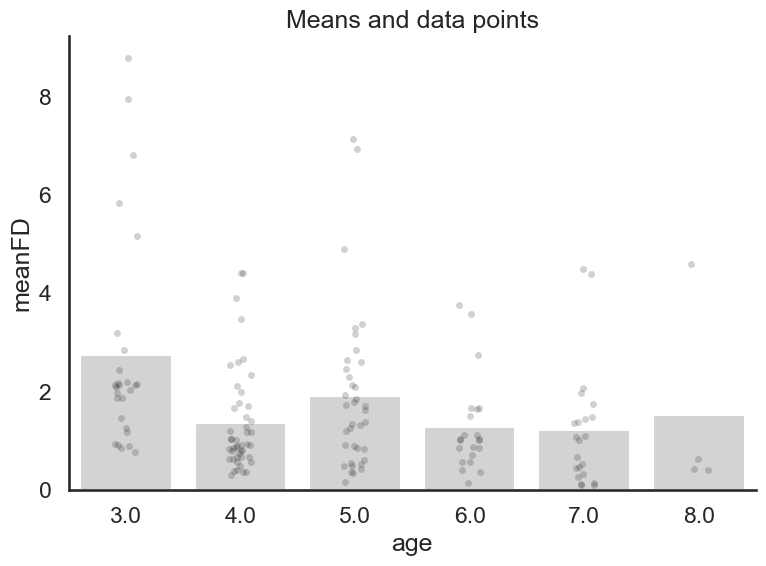

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


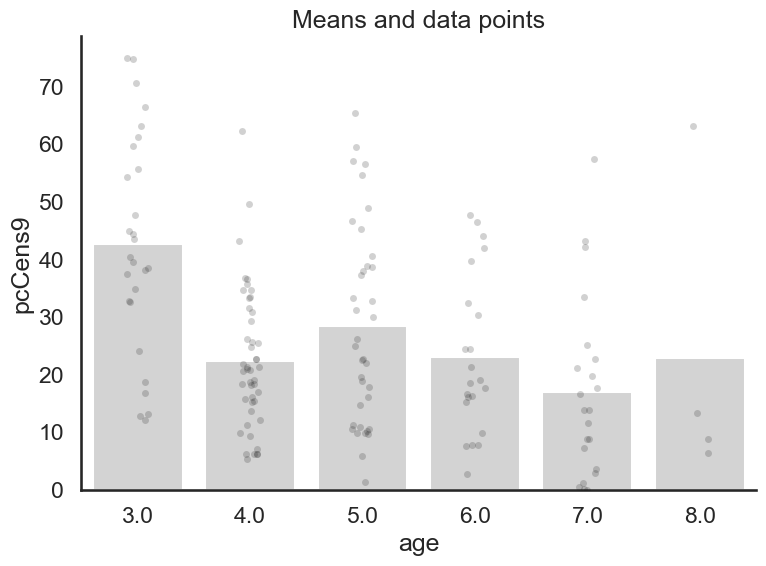

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


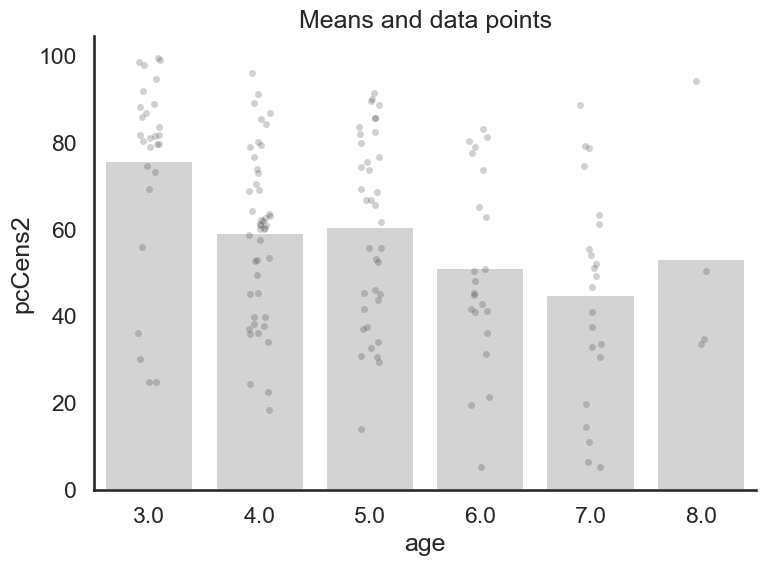

In [13]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### raw data plots - full sample

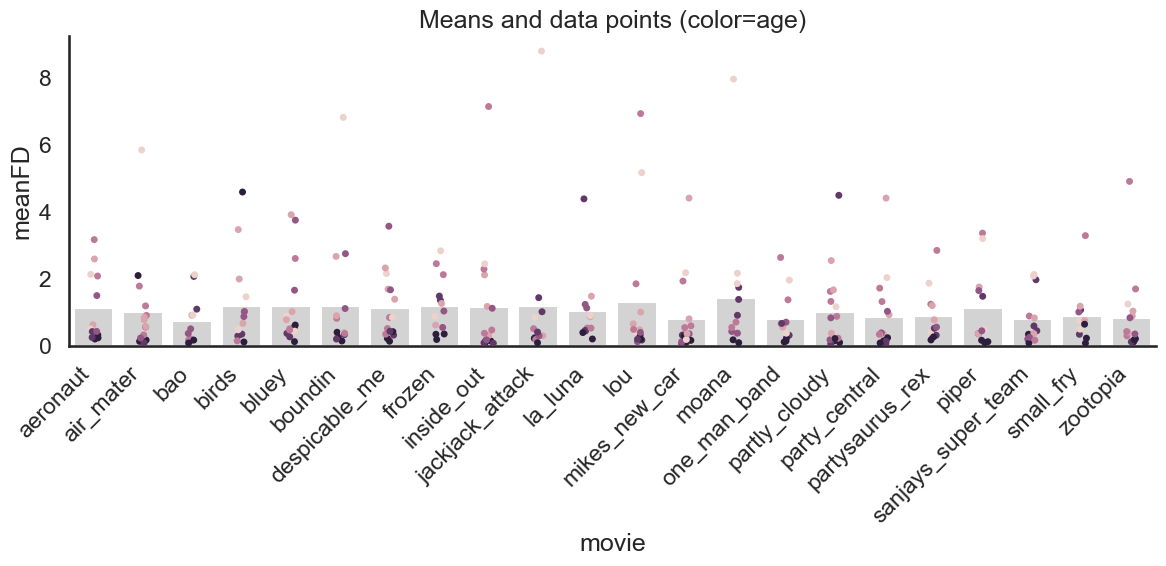

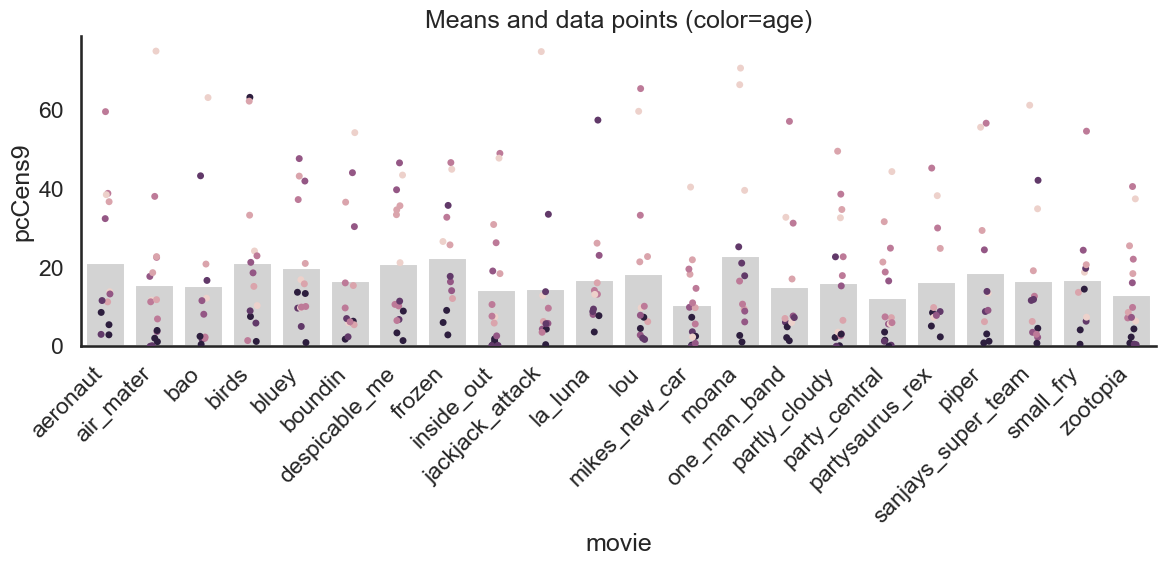

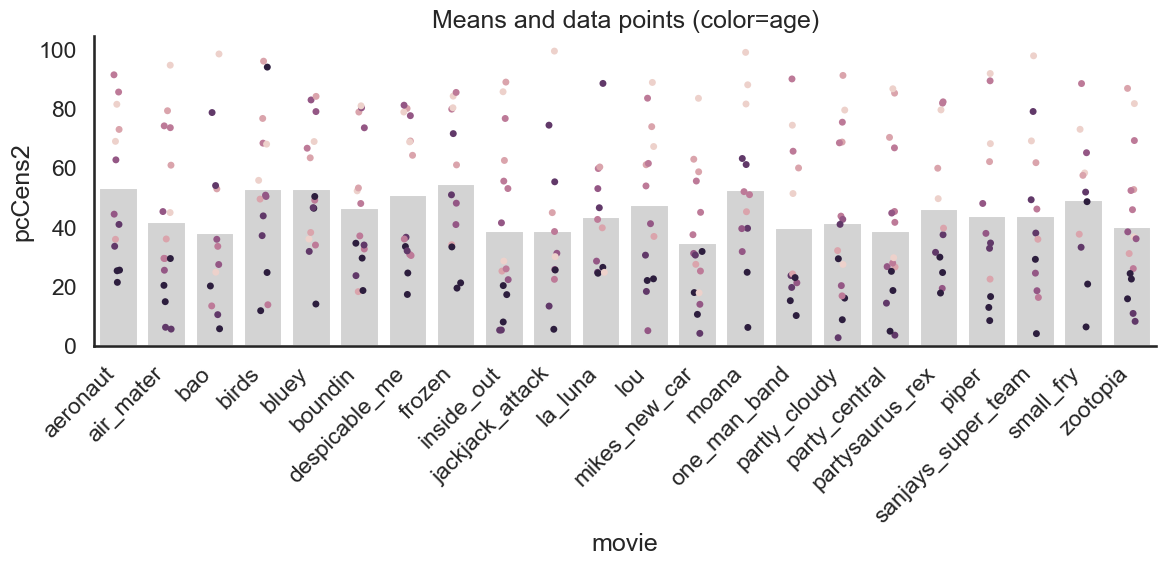

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


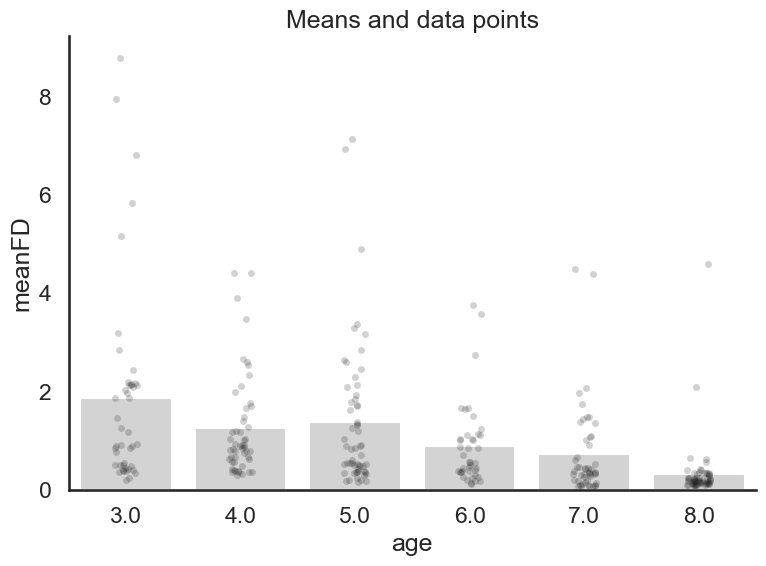

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


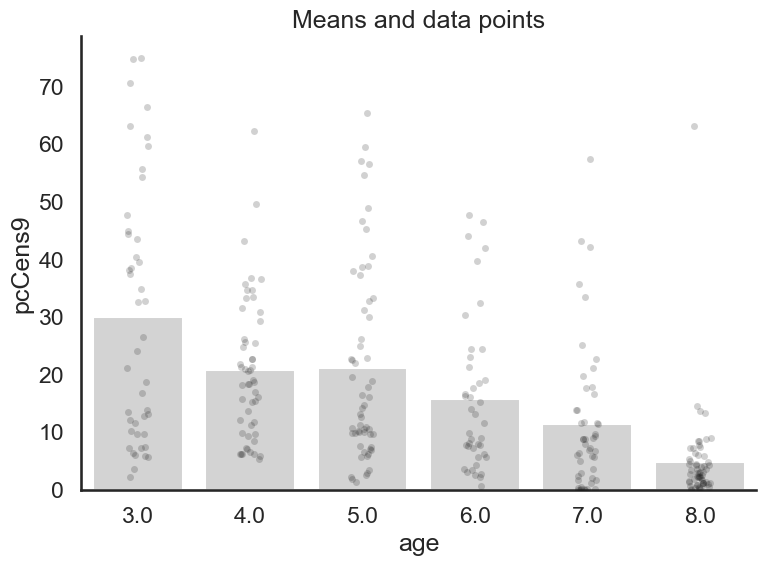

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


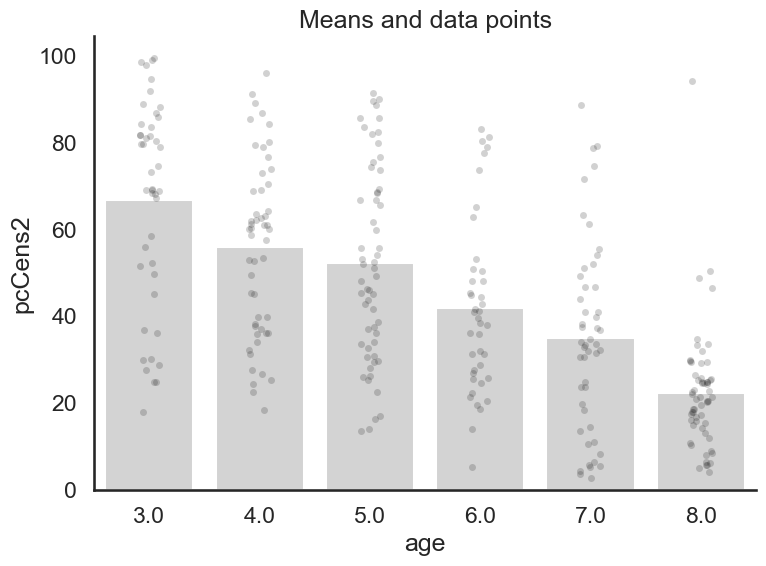

In [14]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data, color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### residualized FD plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


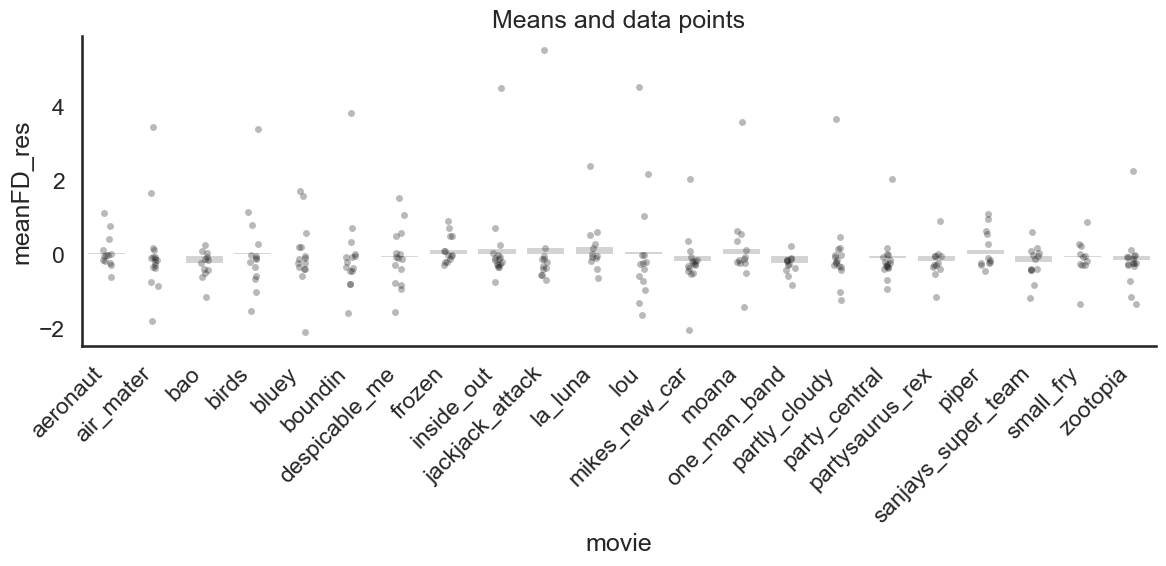

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


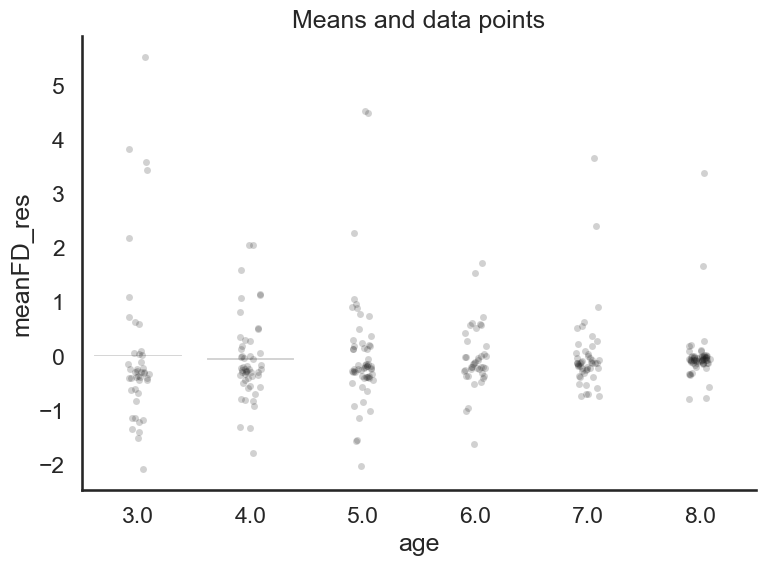

In [15]:
# plot mean residualized FD 
plt.figure(figsize=(12,6))
sns.barplot(y='meanFD_res',x='movie', data=data, color='lightgray',errwidth=0)
sns.stripplot(y='meanFD_res',x='movie', data=data, color='k', alpha=0.3)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.legend().remove()
plt.title('Means and data points')
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, 'fullsample_clip_motion_meanFDres_plot.png'), dpi=200)
plt.show()
plt.close()

plt.figure(figsize=(8,6))
sns.barplot(y='meanFD_res', x='age', data=data, color='lightgray',errwidth=0)
sns.stripplot(y='meanFD_res', x='age', data=data, color='k', alpha=0.2)
plt.legend().remove()
sns.despine()
plt.title('Means and data points')
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, 'fullsample_age_motion_meanFDres_plot.png'), dpi=200)
plt.show()
plt.close()

### analyses of clip category - high motion sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              1.6041   
Min. group size:  2       Log-Likelihood:     -260.7997
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.633    0.584  4.505 0.000  1.488  3.779
human         0.099    0.231  0.431 0.667 -0.353  0.552
age          -0.165    0.115 -1.429 0.153 -0.390  0.061
sex          -0.426    0.318 -1.339 0.181 -1.049  0.198
sub Var       0.381    0.168                           



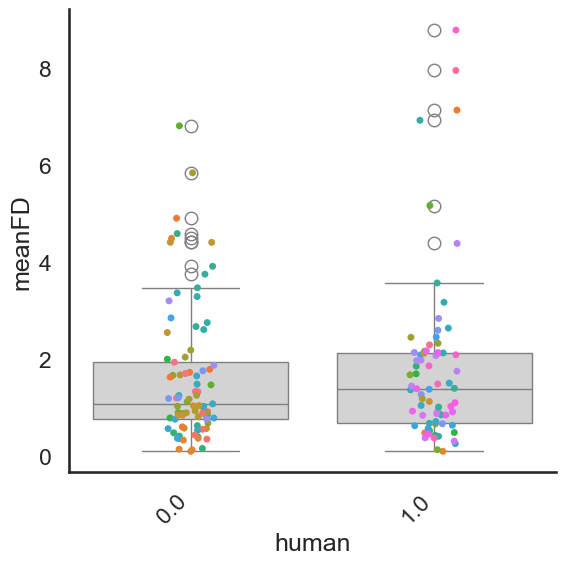


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              1.6092   
Min. group size:  2       Log-Likelihood:     -260.9360
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.678    0.585  4.577 0.000  1.531  3.824
speaking      0.015    0.221  0.068 0.945 -0.417  0.447
age          -0.166    0.115 -1.448 0.148 -0.391  0.059
sex          -0.429    0.317 -1.355 0.176 -1.049  0.192
sub Var       0.375    0.166                           



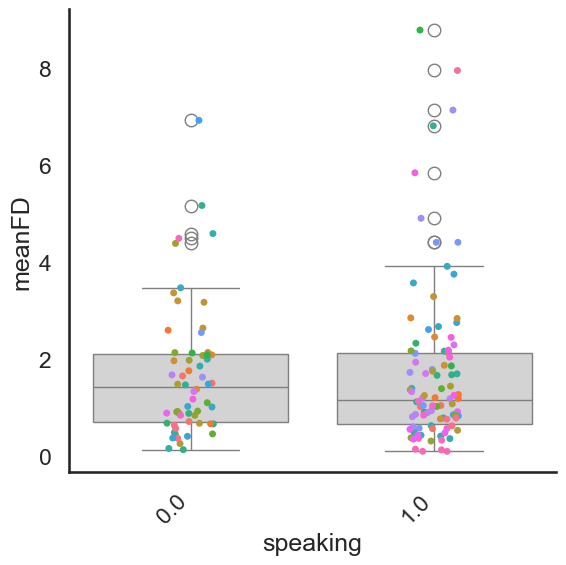


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              1.6057   
Min. group size:  2       Log-Likelihood:     -260.6642
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.782    0.595  4.679 0.000  1.617  3.948
contained    -0.136    0.250 -0.547 0.585 -0.626  0.353
age          -0.164    0.115 -1.431 0.152 -0.389  0.061
sex          -0.426    0.316 -1.348 0.178 -1.047  0.194
sub Var       0.375    0.166                           



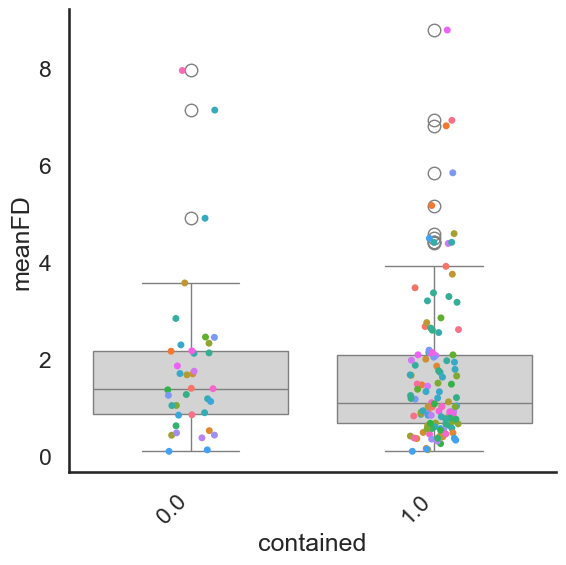


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              133.2294 
Min. group size:  2       Log-Likelihood:     -594.6737
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   45.481    8.129  5.595 0.000  29.548 61.414
human        1.840    2.238  0.822 0.411  -2.547  6.227
age         -2.769    1.617 -1.712 0.087  -5.938  0.401
sex        -11.534    4.499 -2.564 0.010 -20.353 -2.716
sub Var    112.722    3.741                            



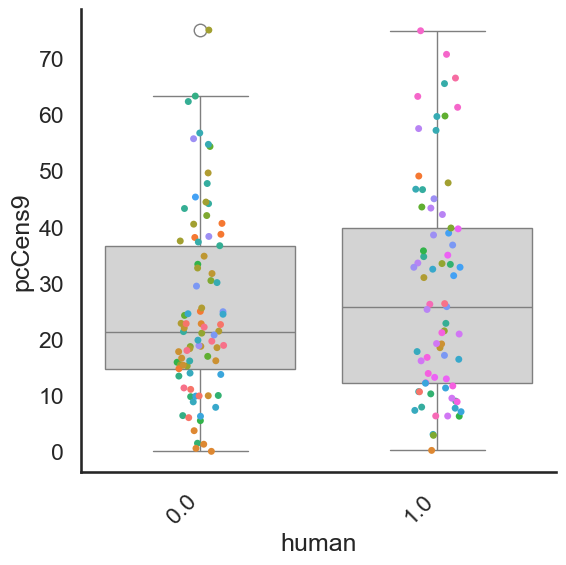


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              132.3982 
Min. group size:  2       Log-Likelihood:     -594.4236
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   47.980    8.138  5.895 0.000  32.029 63.931
speaking    -2.376    2.036 -1.167 0.243  -6.366  1.613
age         -2.805    1.619 -1.733 0.083  -5.977  0.368
sex        -11.570    4.505 -2.568 0.010 -20.399 -2.741
sub Var    113.262    3.760                            



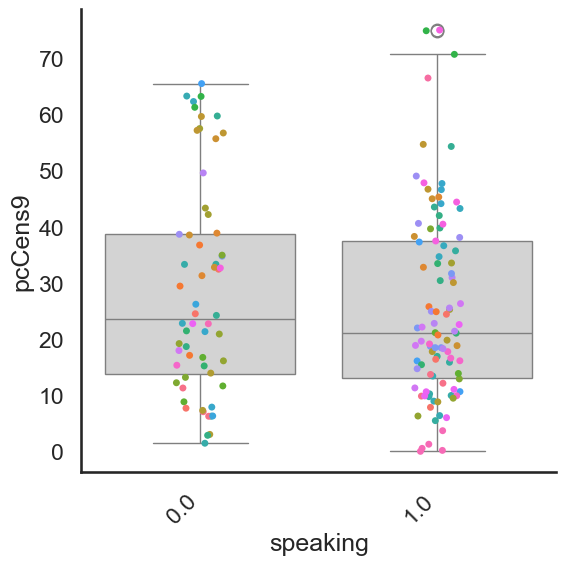


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              132.2055 
Min. group size:  2       Log-Likelihood:     -594.3695
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   48.285    8.240  5.860 0.000  32.135 64.434
contained   -2.543    2.276 -1.117 0.264  -7.004  1.918
age         -2.763    1.628 -1.697 0.090  -5.954  0.428
sex        -11.550    4.530 -2.550 0.011 -20.430 -2.671
sub Var    114.881    3.806                            



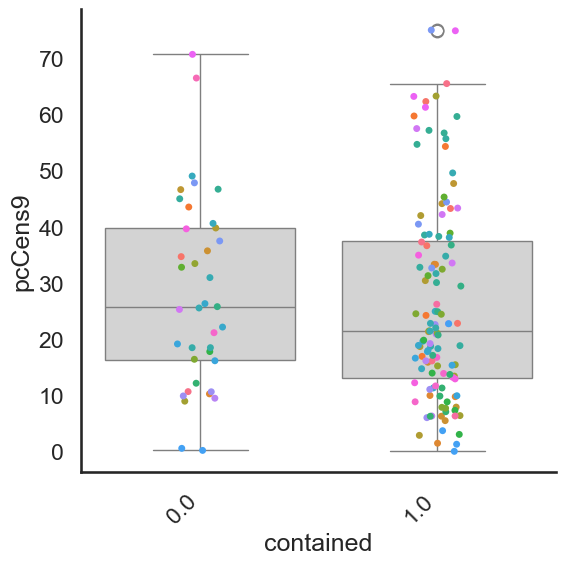


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              211.1243 
Min. group size:  2       Log-Likelihood:     -630.3679
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  86.701   11.073  7.830 0.000  64.999 108.404
human       1.329    2.837  0.468 0.640  -4.232   6.889
age        -3.981    2.206 -1.805 0.071  -8.304   0.342
sex       -15.994    6.142 -2.604 0.009 -28.032  -3.957
sub Var   217.329    5.500                             



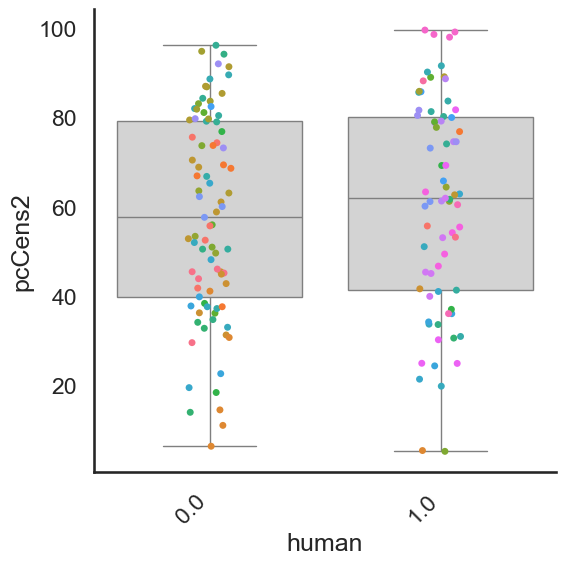


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              211.3577 
Min. group size:  2       Log-Likelihood:     -630.5739
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  87.432   11.088  7.885 0.000  65.699 109.165
speaking    0.035    2.576  0.014 0.989  -5.014   5.085
age        -4.006    2.209 -1.814 0.070  -8.335   0.323
sex       -16.044    6.151 -2.608 0.009 -28.101  -3.988
sub Var   218.152    5.516                             



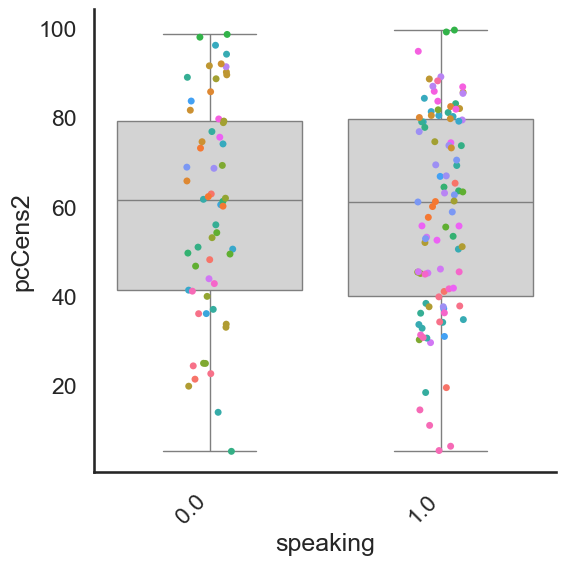


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 150     Method:             REML     
No. Groups:       29      Scale:              207.9581 
Min. group size:  2       Log-Likelihood:     -629.4643
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  90.264   11.142  8.102 0.000  68.427 112.101
contained  -4.052    2.856 -1.419 0.156  -9.649   1.545
age        -3.942    2.207 -1.786 0.074  -8.267   0.383
sex       -15.962    6.146 -2.597 0.009 -28.007  -3.917
sub Var   218.330    5.550                             



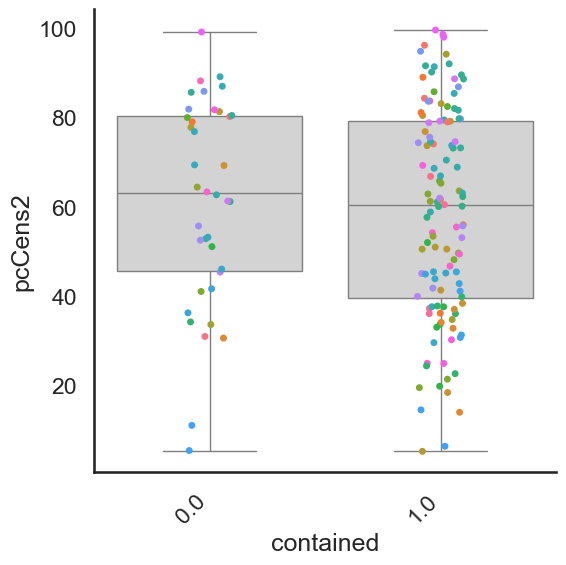

In [16]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', 
                          data=temp.loc[temp['motiongroup']=='high',:]).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], color='lightgray')
        sns.stripplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'highsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), 
                    dpi=200)
        plt.show()
        plt.close()

### analyses of clip category - full sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.8530   
Min. group size:  2       Log-Likelihood:     -426.3926
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.594    0.401  6.472 0.000  1.809  3.380
human         0.061    0.128  0.475 0.635 -0.191  0.313
age          -0.262    0.065 -4.063 0.000 -0.389 -0.136
sex          -0.253    0.219 -1.155 0.248 -0.683  0.176
sub Var       0.488    0.155                           



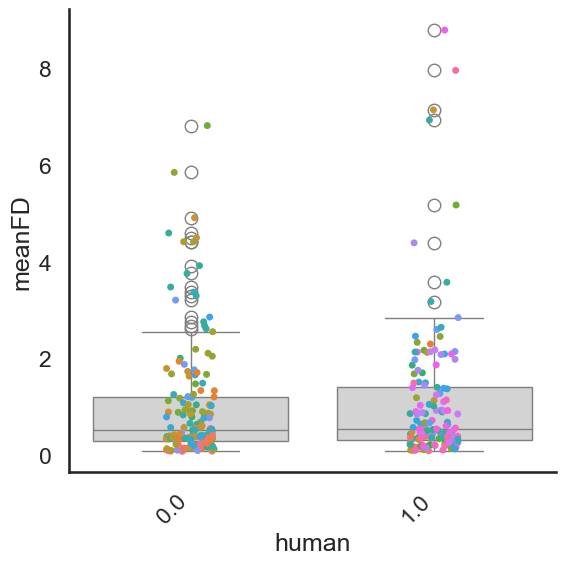


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.8543   
Min. group size:  2       Log-Likelihood:     -426.5860
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.608    0.404  6.459 0.000  1.817  3.399
speaking      0.020    0.117  0.169 0.866 -0.209  0.249
age          -0.261    0.064 -4.056 0.000 -0.387 -0.135
sex          -0.255    0.219 -1.164 0.244 -0.684  0.174
sub Var       0.486    0.155                           



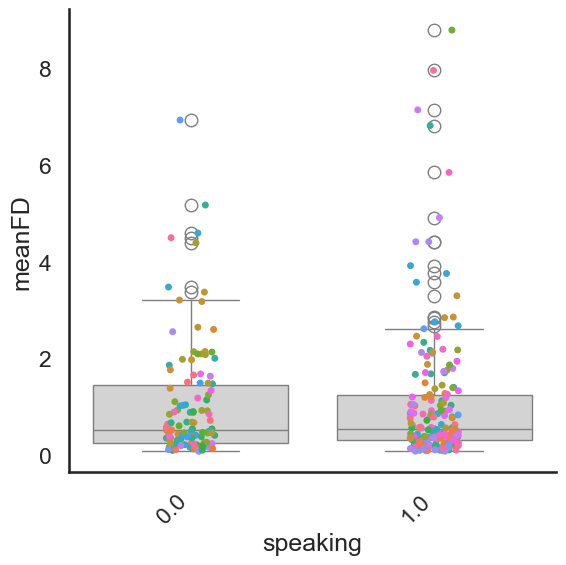


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.8518   
Min. group size:  2       Log-Likelihood:     -426.1876
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.693    0.407  6.609 0.000  1.894  3.491
contained    -0.101    0.131 -0.771 0.441 -0.358  0.156
age          -0.260    0.064 -4.039 0.000 -0.387 -0.134
sex          -0.252    0.219 -1.151 0.250 -0.682  0.177
sub Var       0.488    0.155                           



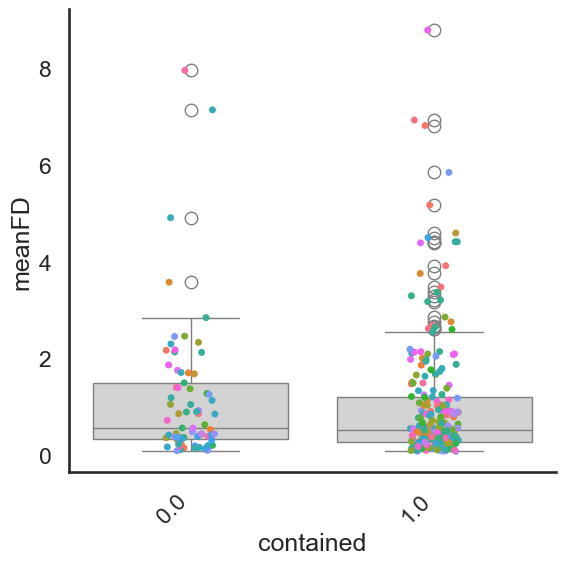


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              79.3716   
Min. group size:  2       Log-Likelihood:     -1092.8313
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    45.192    5.976  7.562 0.000  33.479 56.905
human         1.315    1.292  1.018 0.309  -1.217  3.847
age          -4.542    0.967 -4.699 0.000  -6.437 -2.648
sex          -6.539    3.279 -1.994 0.046 -12.967 -0.112
sub Var     131.143    3.609                            



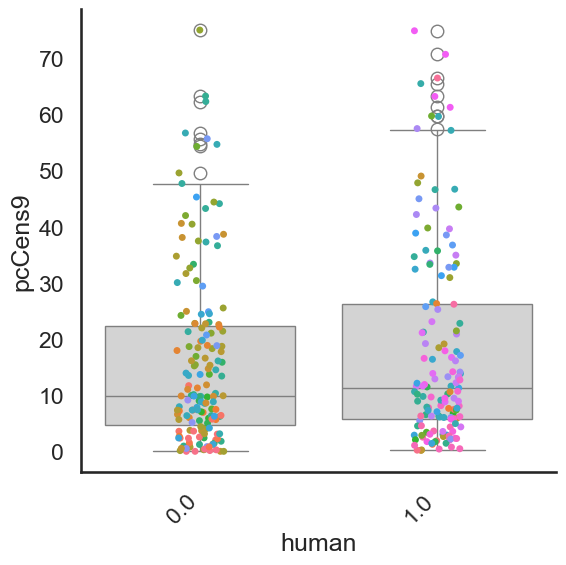


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              79.5781   
Min. group size:  2       Log-Likelihood:     -1093.2850
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    46.247    5.998  7.711 0.000  34.492 58.002
speaking     -0.704    1.139 -0.619 0.536  -2.936  1.527
age          -4.536    0.967 -4.690 0.000  -6.432 -2.641
sex          -6.567    3.281 -2.002 0.045 -12.997 -0.137
sub Var     131.241    3.608                            



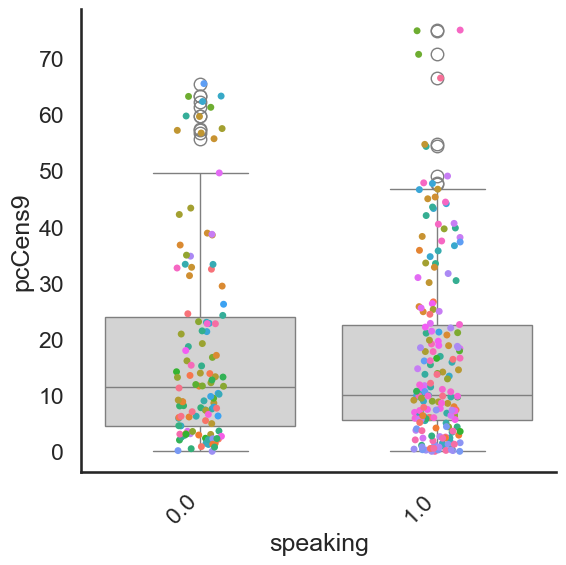


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              78.1387   
Min. group size:  2       Log-Likelihood:     -1091.3105
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    47.594    6.045  7.873 0.000  35.745 59.442
contained    -2.565    1.258 -2.039 0.041  -5.030 -0.099
age          -4.503    0.972 -4.633 0.000  -6.408 -2.598
sex          -6.507    3.297 -1.974 0.048 -12.969 -0.046
sub Var     132.961    3.677                            



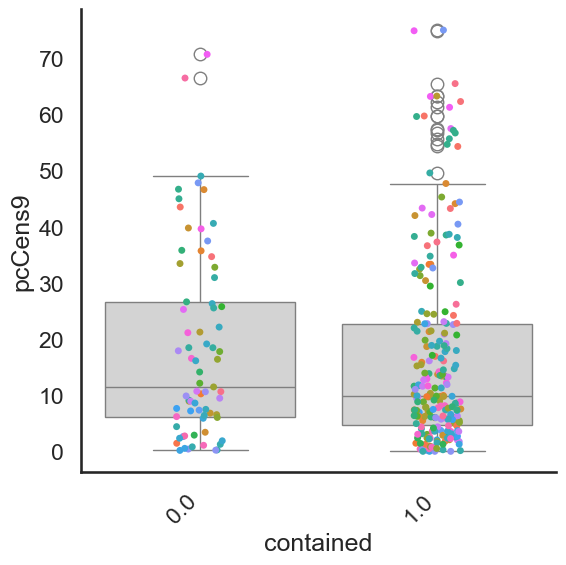


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              149.7694  
Min. group size:  2       Log-Likelihood:     -1185.3880
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept   95.145    8.594 11.071 0.000  78.300 111.989
human        0.547    1.780  0.308 0.758  -2.941   4.035
age         -8.281    1.391 -5.954 0.000 -11.007  -5.555
sex         -6.917    4.717 -1.466 0.143 -16.162   2.328
sub Var    274.239    5.407                             



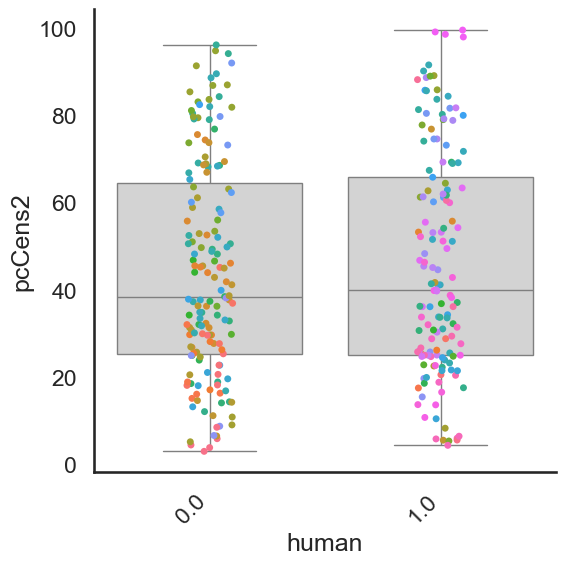


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              149.4209  
Min. group size:  2       Log-Likelihood:     -1185.3409
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept   94.702    8.634 10.969 0.000  77.780 111.624
speaking     1.046    1.561  0.670 0.503  -2.014   4.107
age         -8.263    1.393 -5.931 0.000 -10.994  -5.533
sex         -6.944    4.725 -1.469 0.142 -16.205   2.318
sub Var    275.405    5.434                             



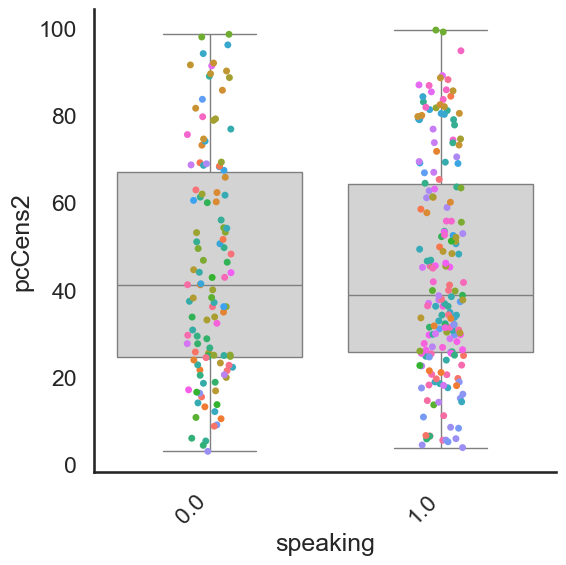


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 288     Method:             REML      
No. Groups:       55      Scale:              145.8678  
Min. group size:  2       Log-Likelihood:     -1182.5611
Max. group size:  6       Converged:          Yes       
Mean group size:  5.2                                   
--------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept   98.328    8.678 11.331 0.000  81.319 115.336
contained   -4.166    1.719 -2.424 0.015  -7.535  -0.797
age         -8.233    1.397 -5.895 0.000 -10.970  -5.496
sex         -6.822    4.736 -1.440 0.150 -16.105   2.462
sub Var    277.532    5.525                             



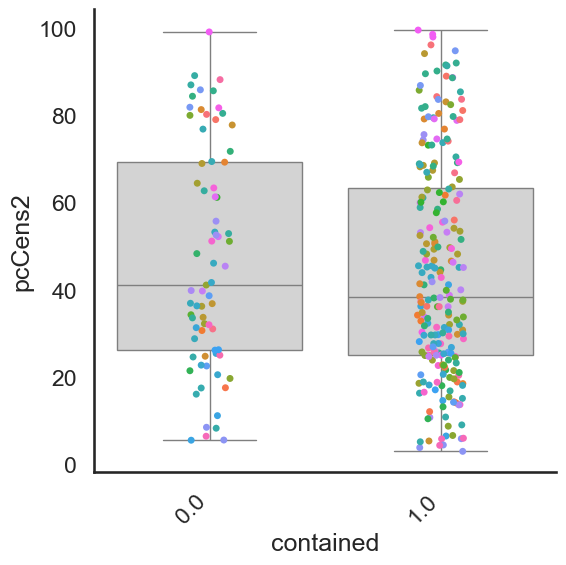

In [17]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data, color='lightgray')
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()
        
        

# Plots by age group - full sample

## 3-4 year olds

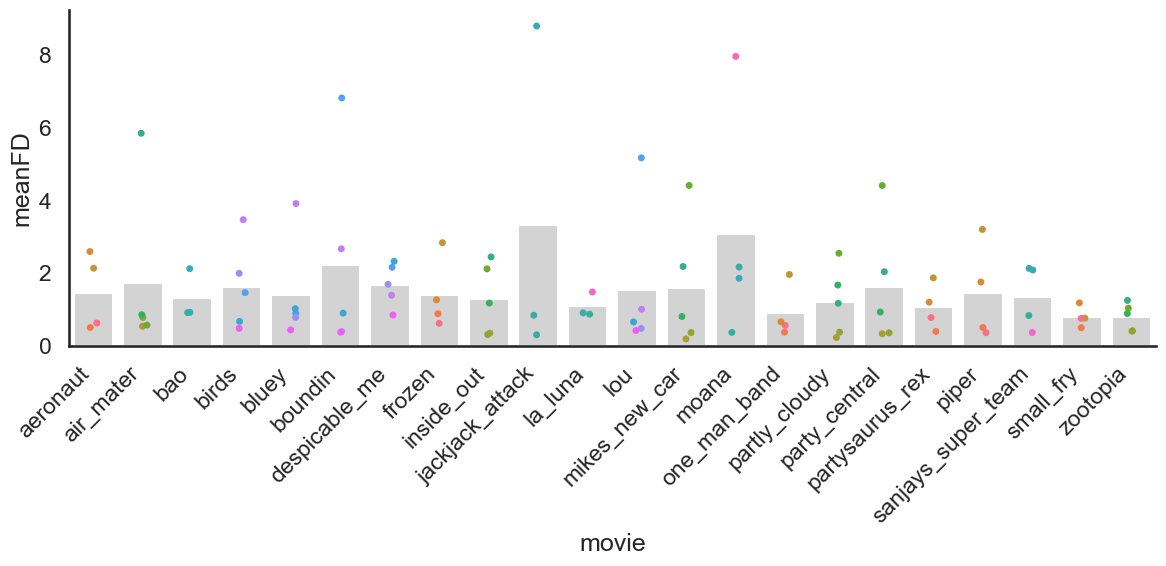

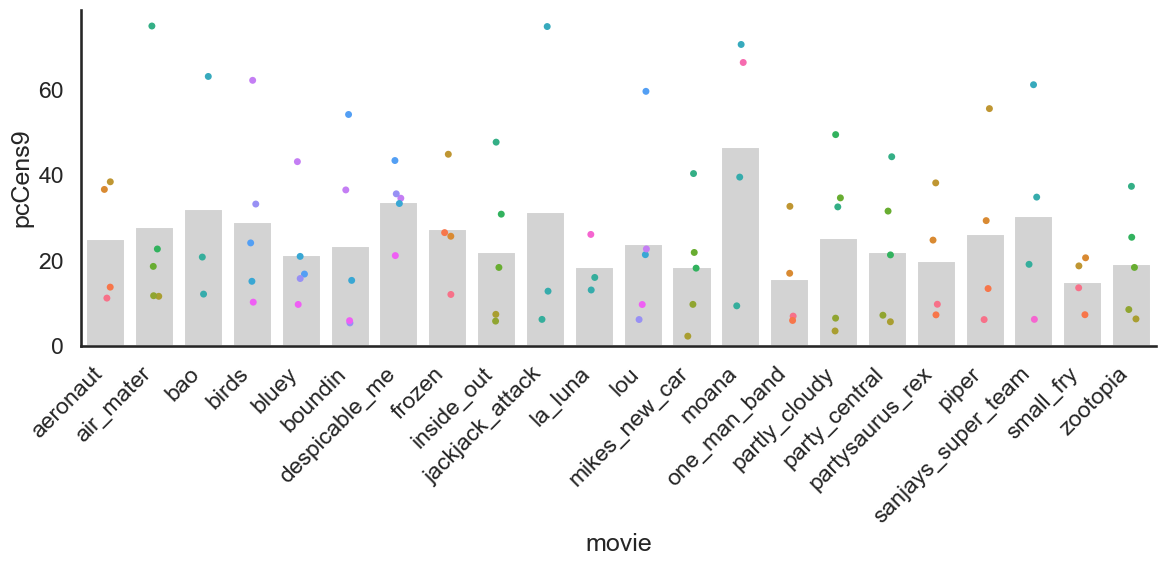

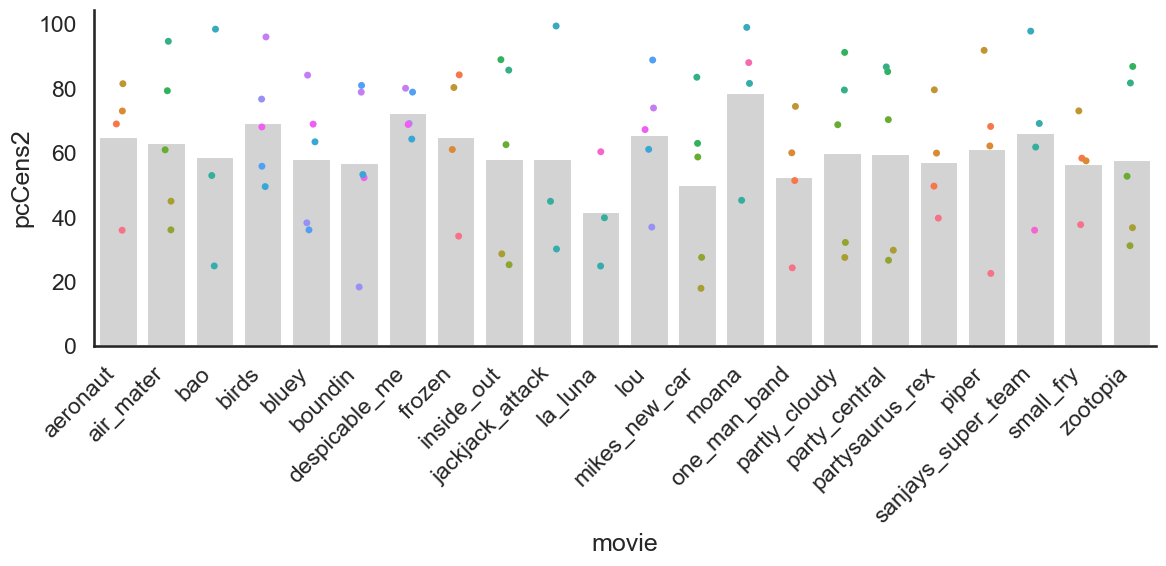

In [18]:
tempdata = data.loc[data['age']<5,:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages34_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 5-6 year olds

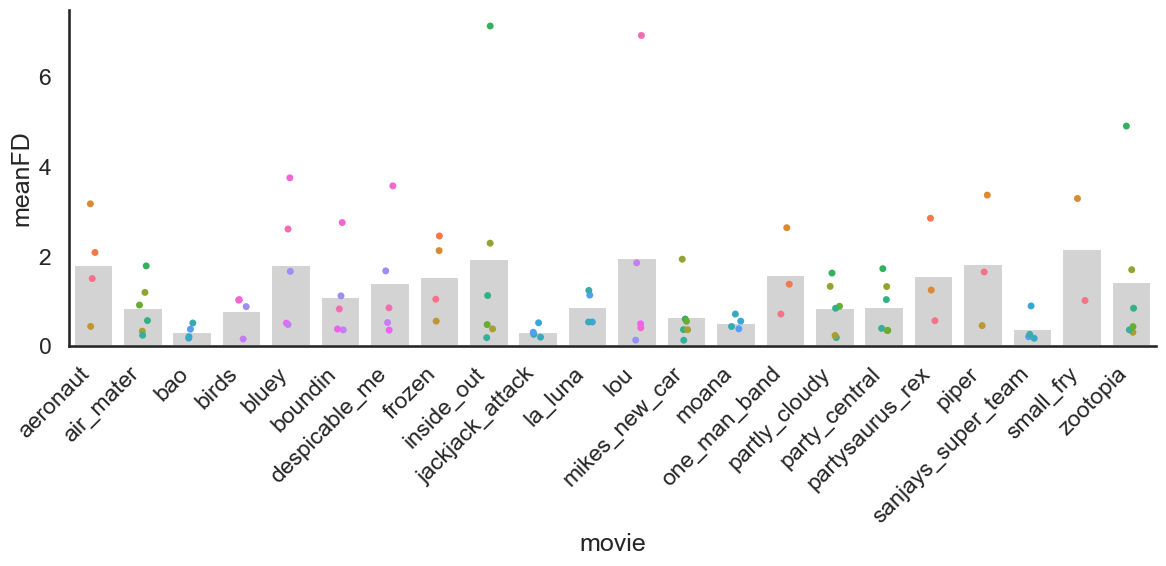

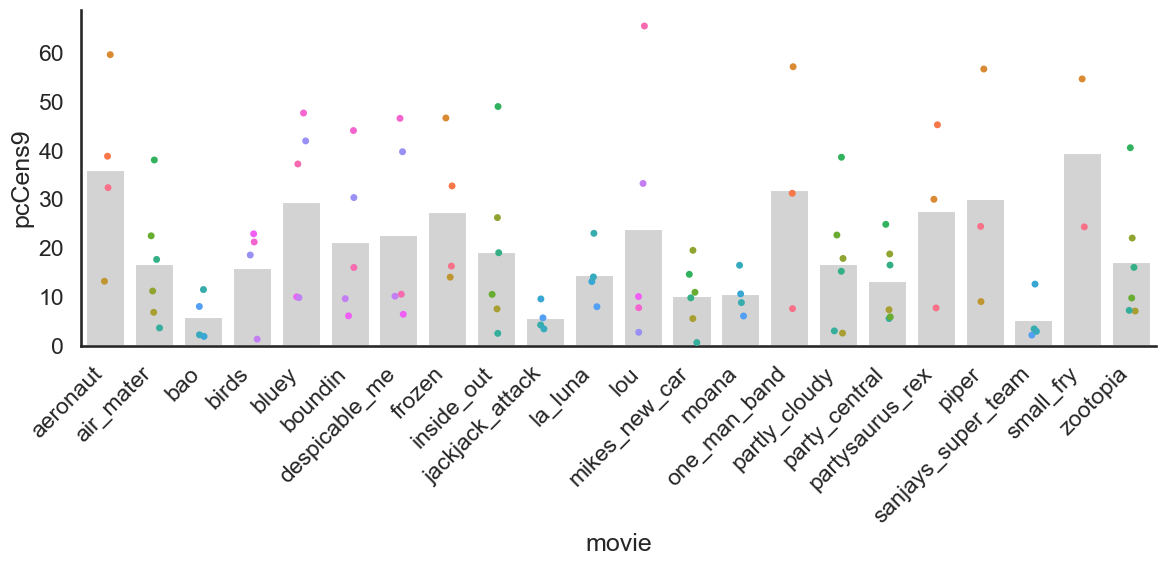

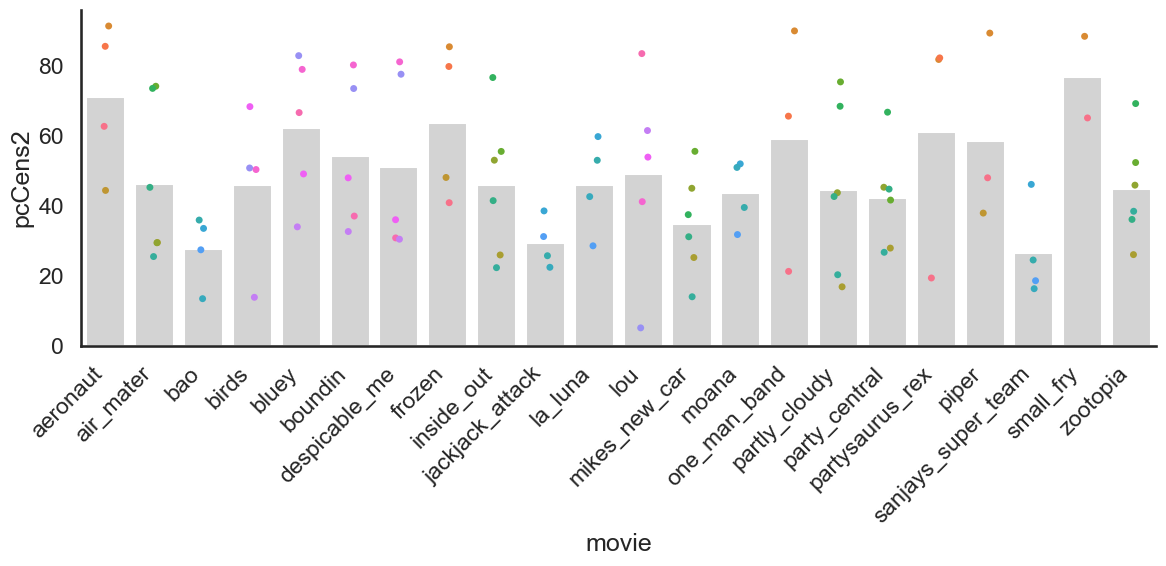

In [19]:
tempdata = data.loc[(data['age']==5) | (data['age']==6),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages56_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 7-8 year olds

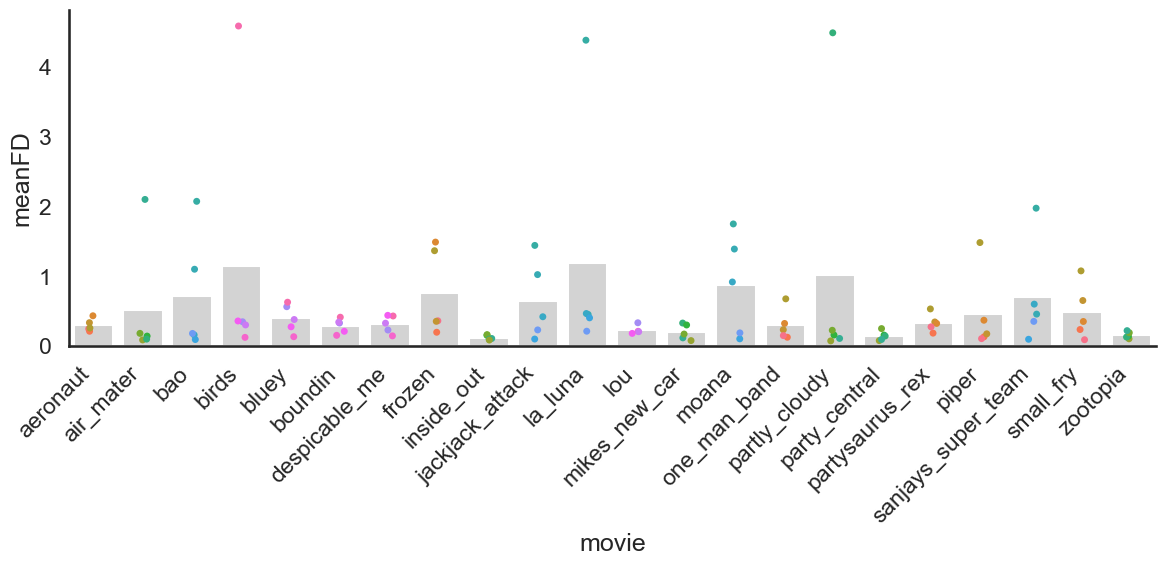

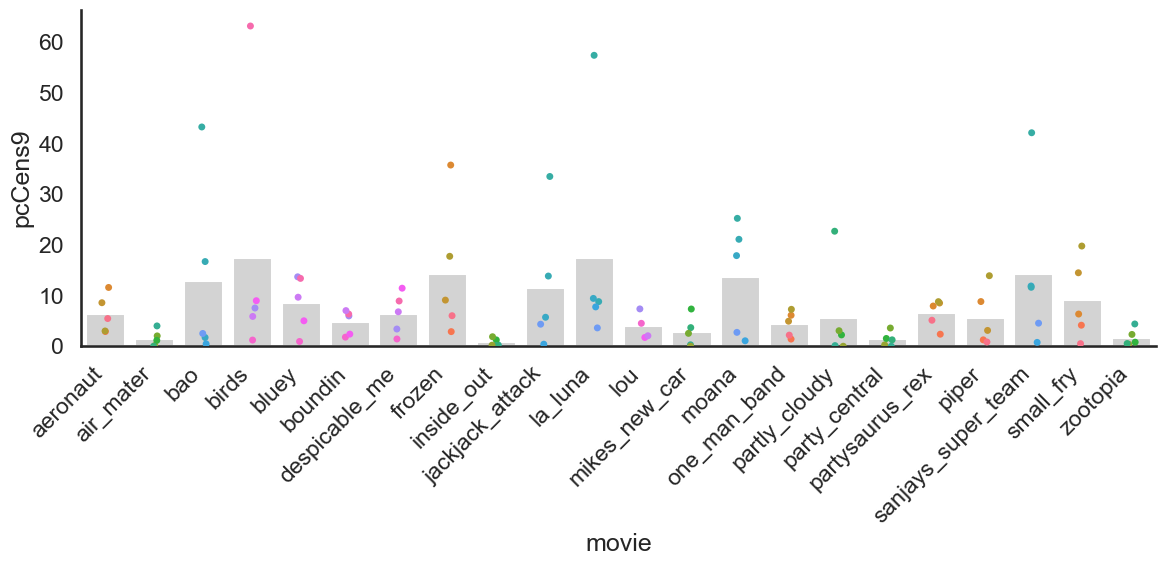

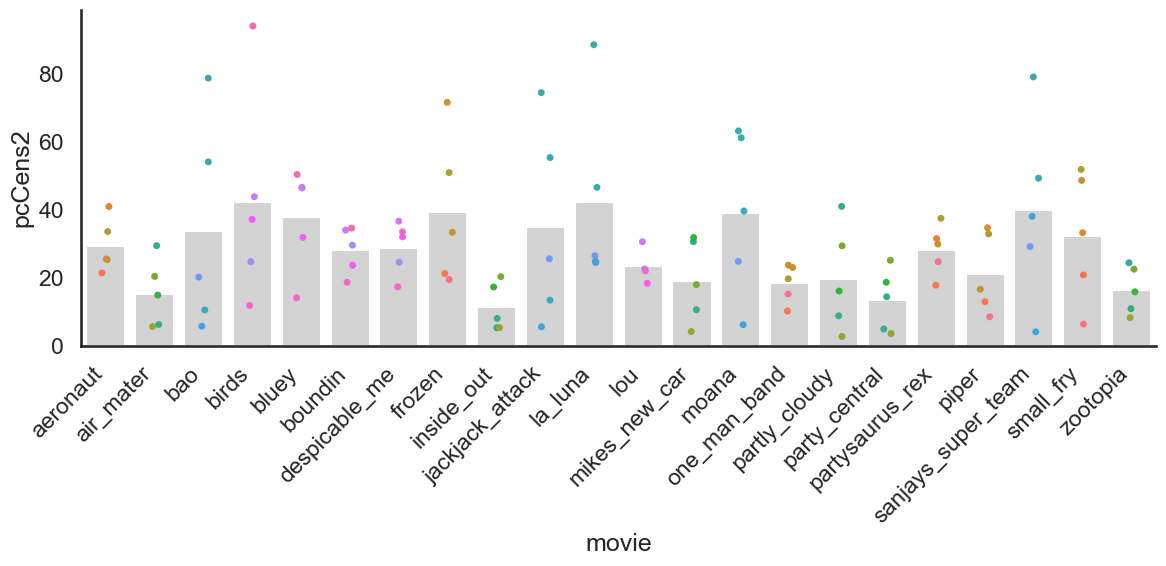

In [20]:
tempdata = data.loc[(data['age']==7) | (data['age']==8),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages78_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

# get timeseries of motion across clips

In [21]:
clipmotion = {}
for mov in clipinfo.index:
    clipmotion[mov] = pd.DataFrame(index=range(0,3001))

In [22]:
for sub in subs:
    print(sub)
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_data_processed.csv'.format(sub)), index_col=0)
    clips = np.unique(subdata['title'].dropna())
    for clip in clips:
        temp = subdata.loc[subdata['title']==clip,'FD50'].to_numpy()
        clipmotion[clip].loc[:temp.shape[0]-1,sub] = temp
        

2002
2003
2004
2005
2006
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2042
2043
2044
2045
2046
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2063
2065
2067
2068
2071


In [23]:
for mov in clipinfo.index:
    clipmotion[mov] = clipmotion[mov].dropna(axis=0,how='all')

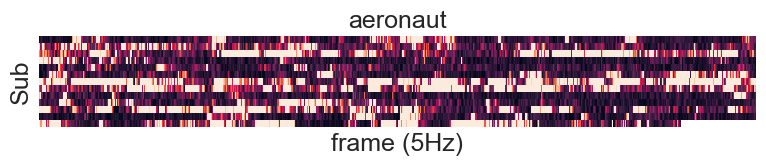

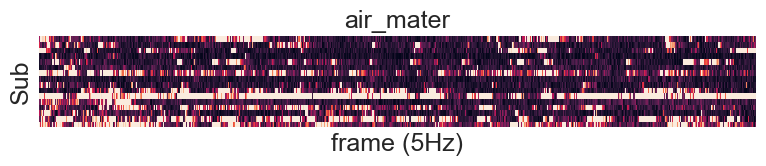

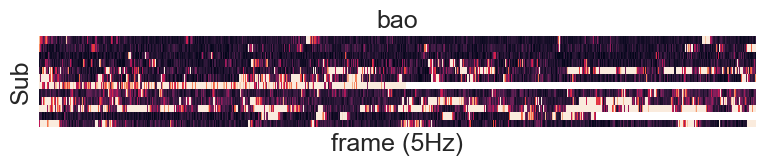

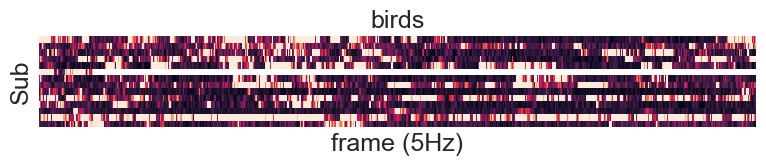

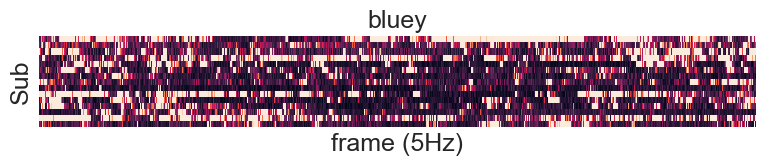

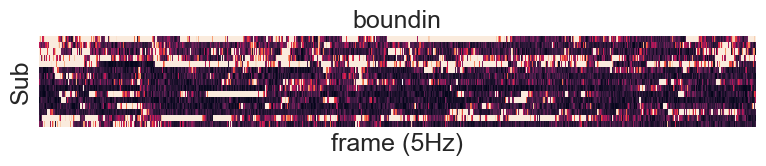

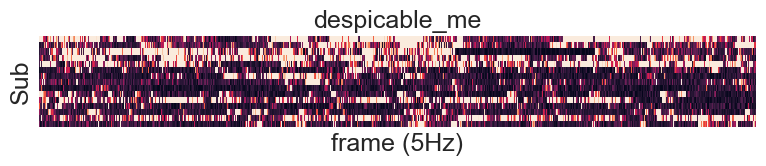

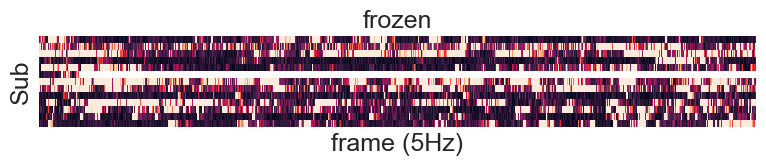

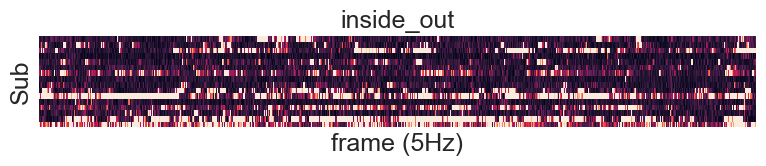

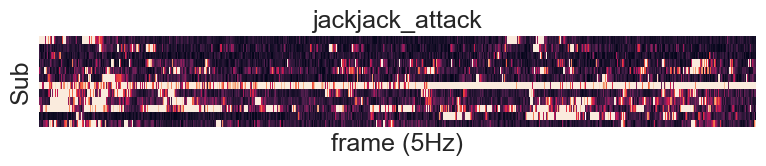

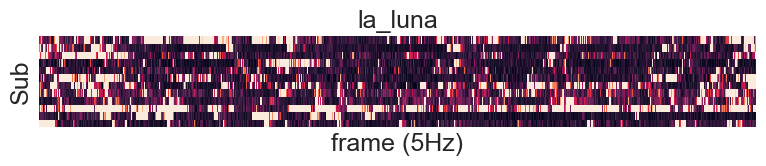

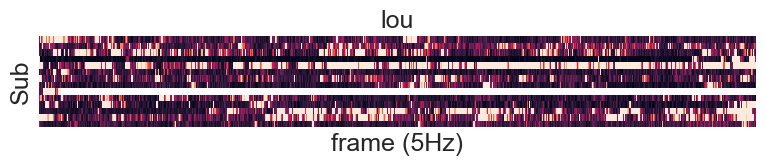

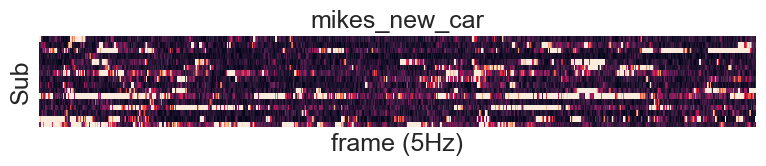

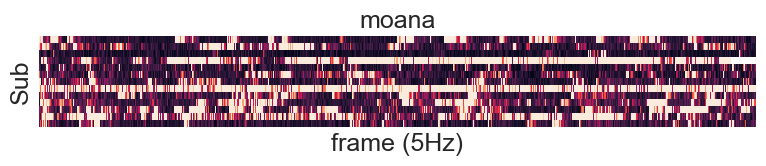

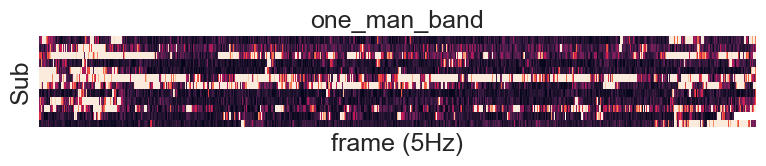

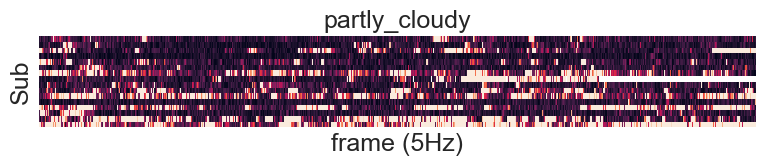

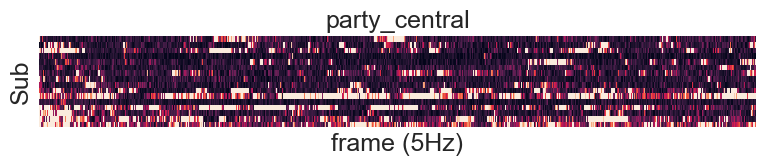

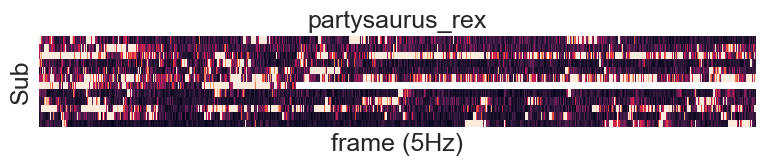

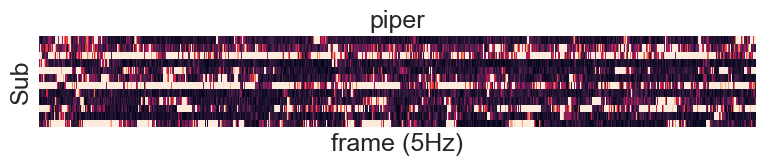

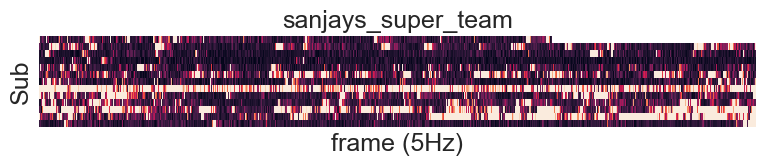

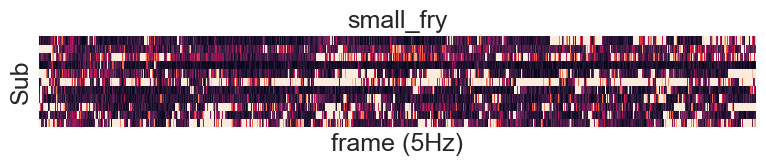

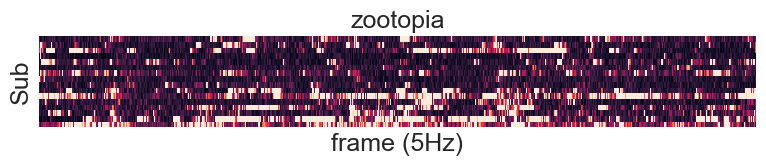

In [24]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_FD_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

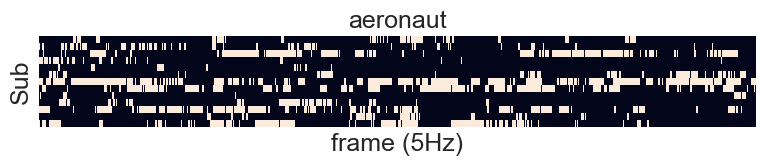

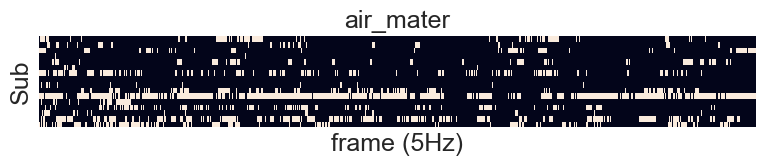

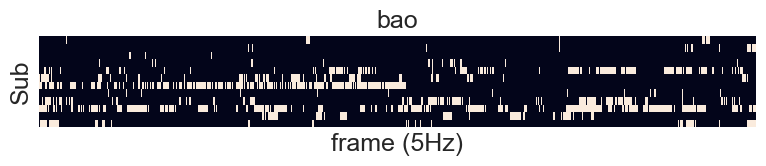

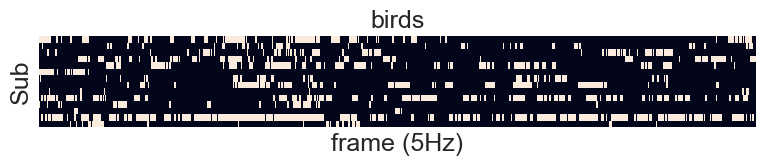

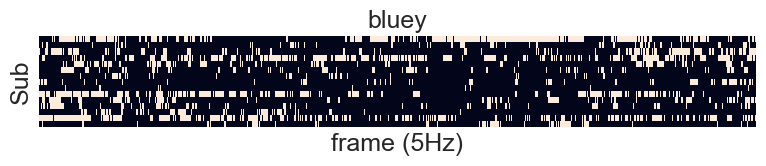

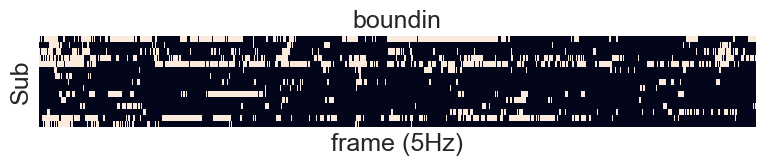

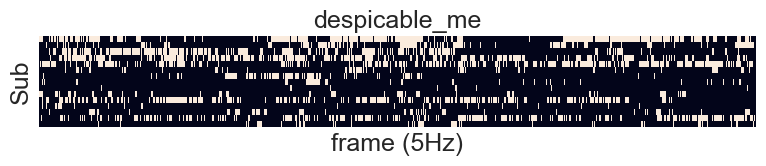

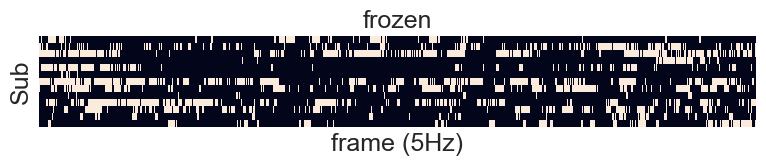

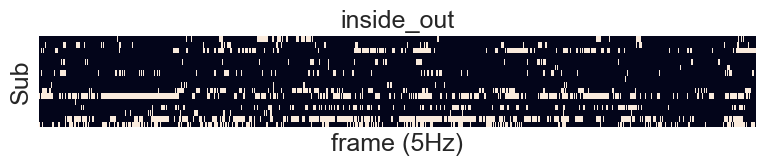

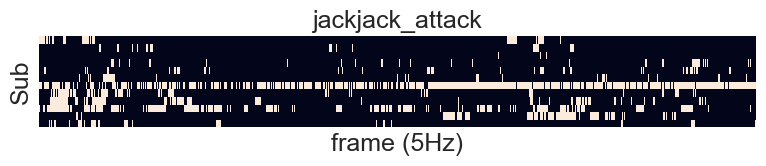

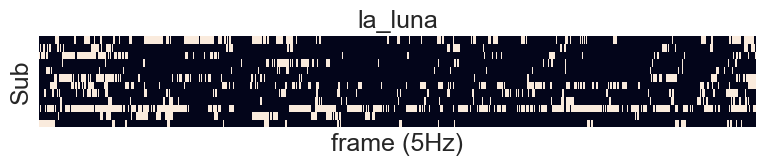

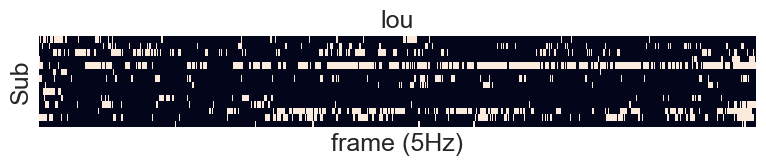

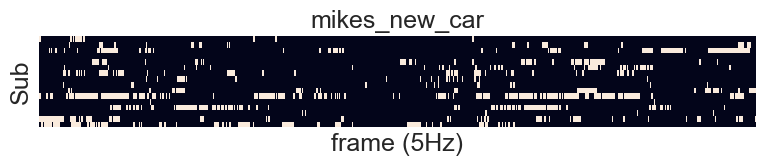

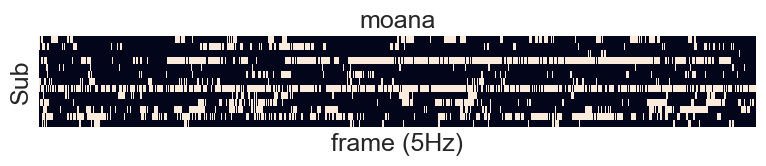

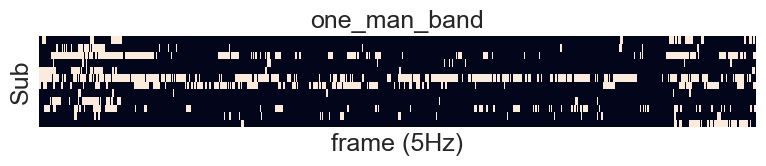

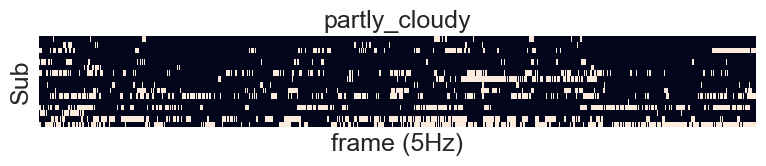

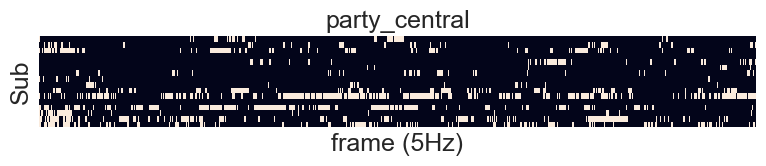

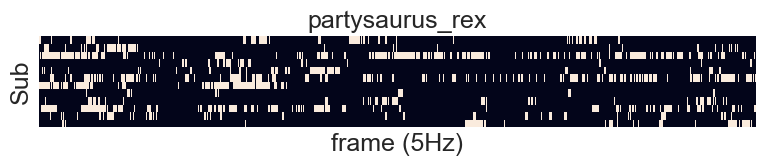

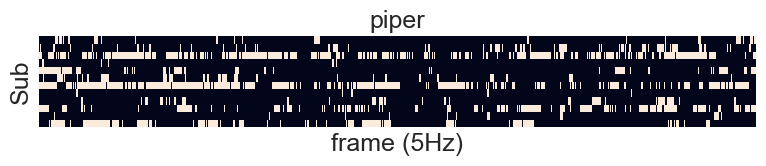

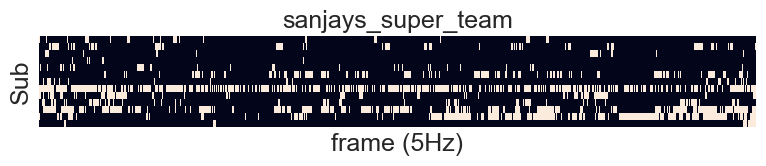

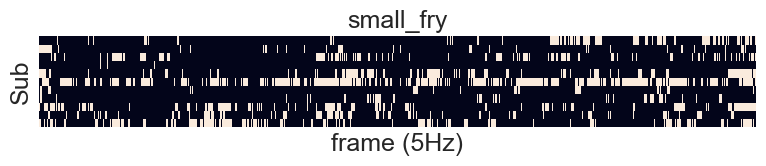

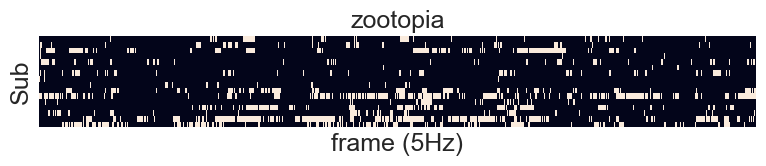

In [25]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.9, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens09_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

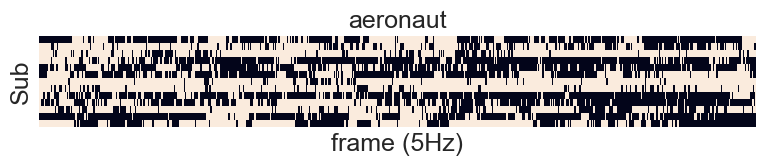

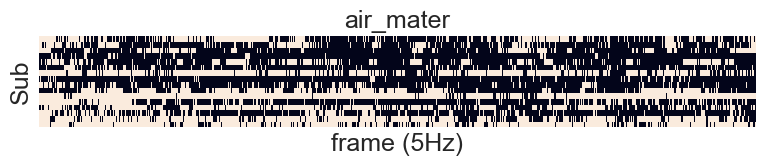

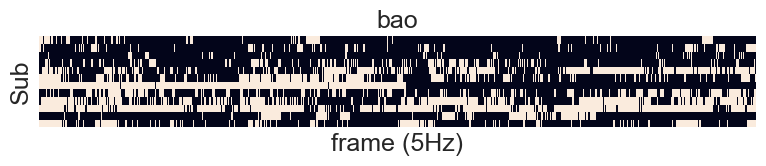

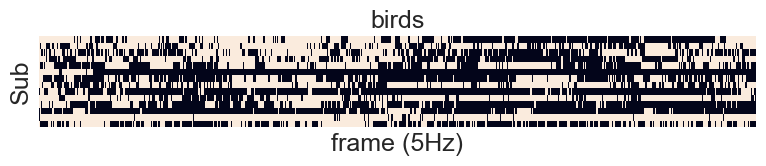

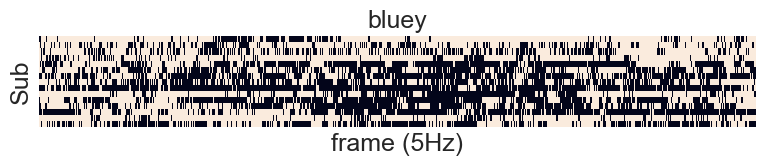

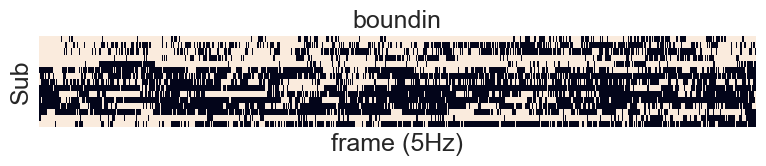

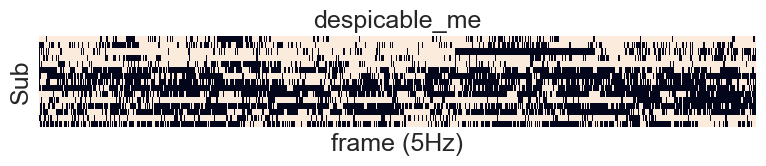

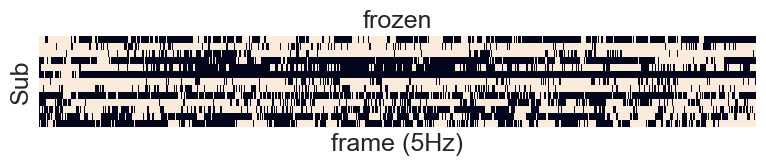

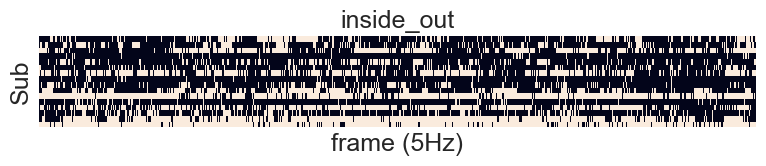

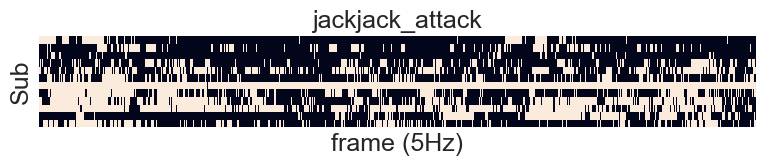

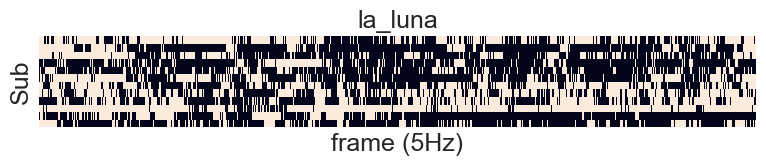

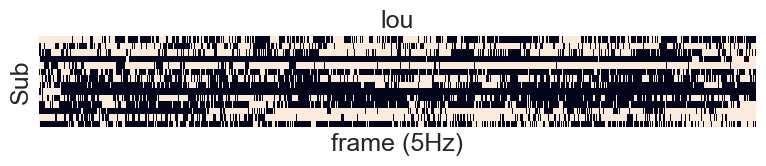

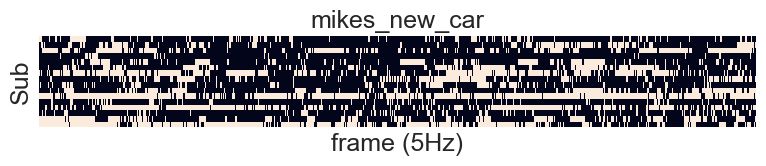

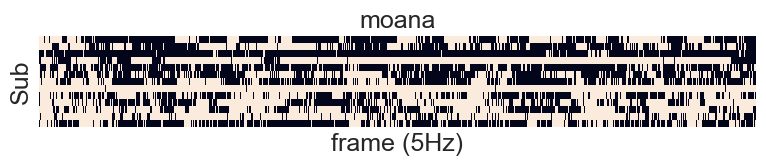

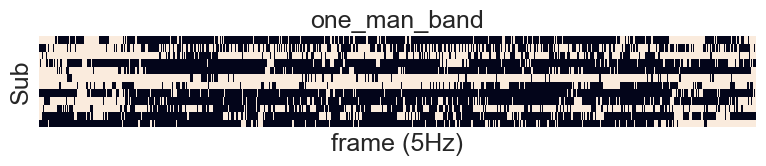

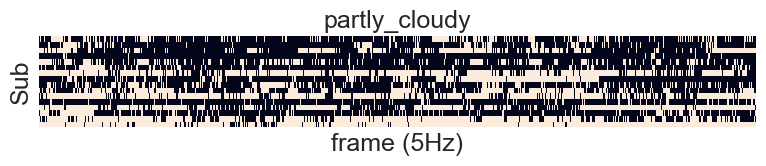

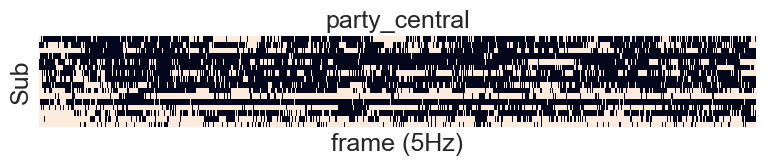

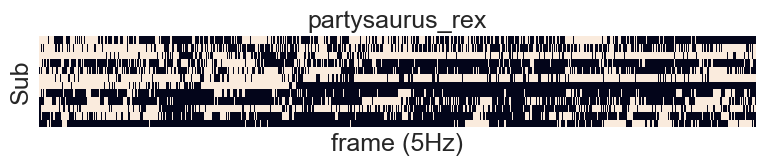

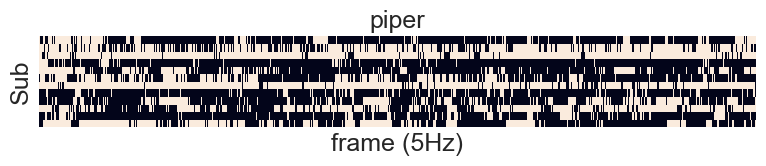

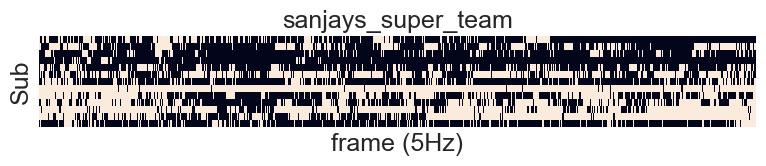

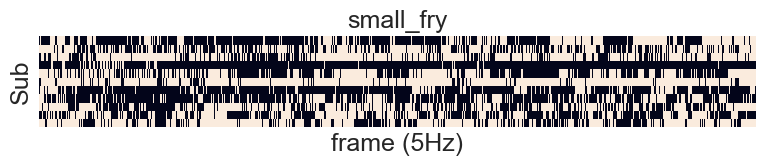

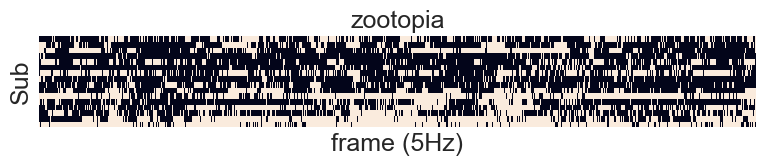

In [26]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.2, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens02_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

# examine ratings

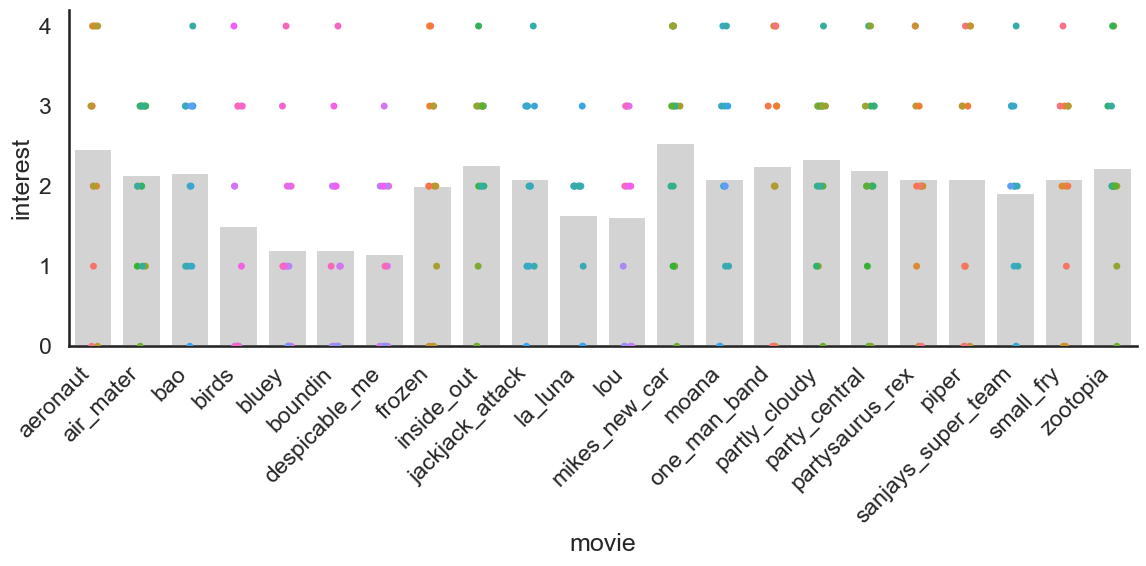

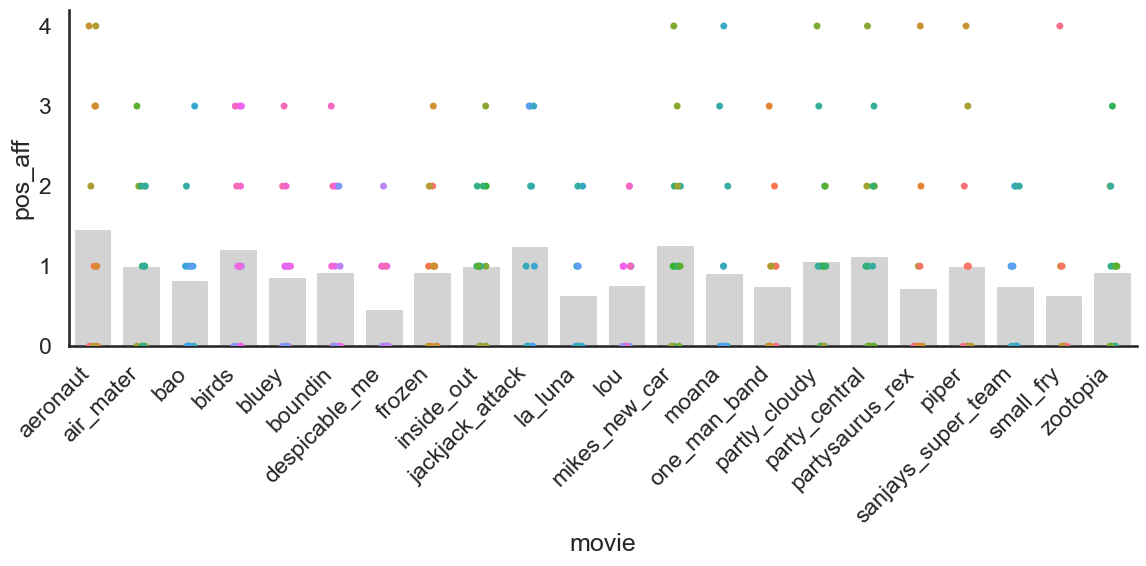

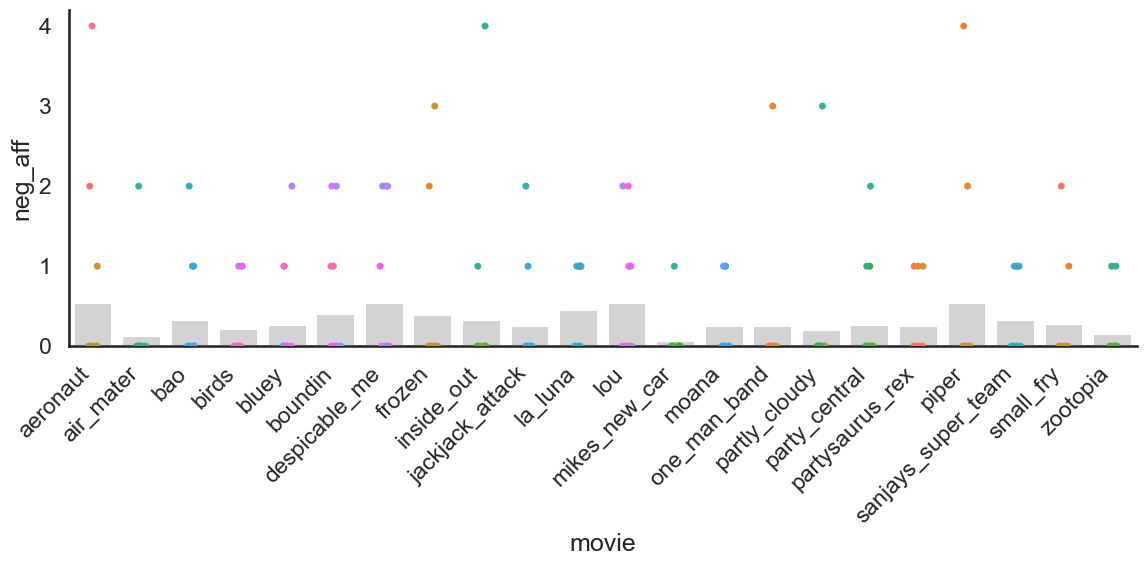

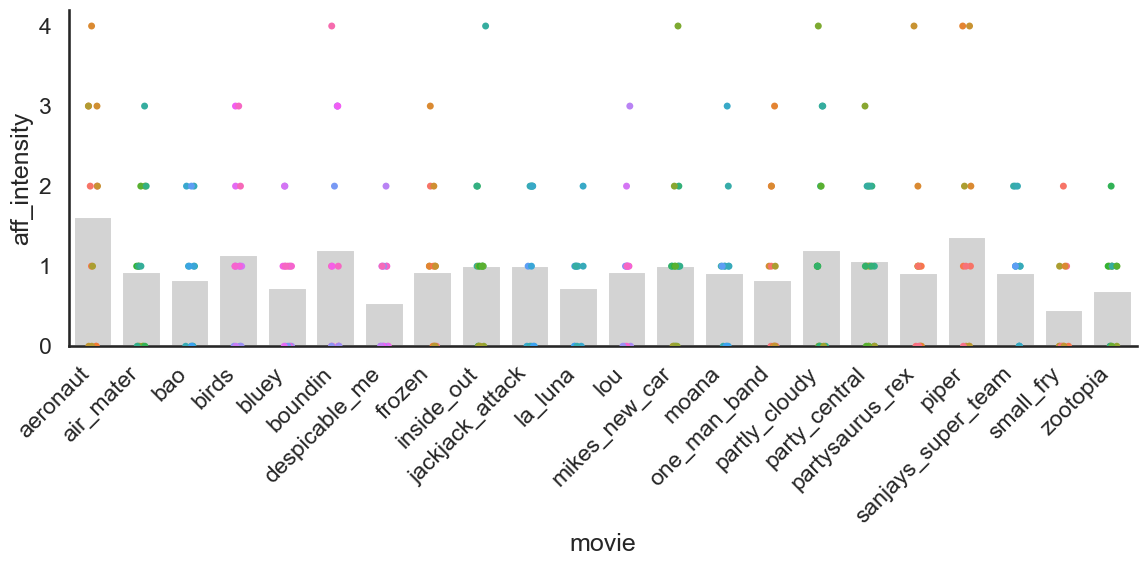

In [27]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

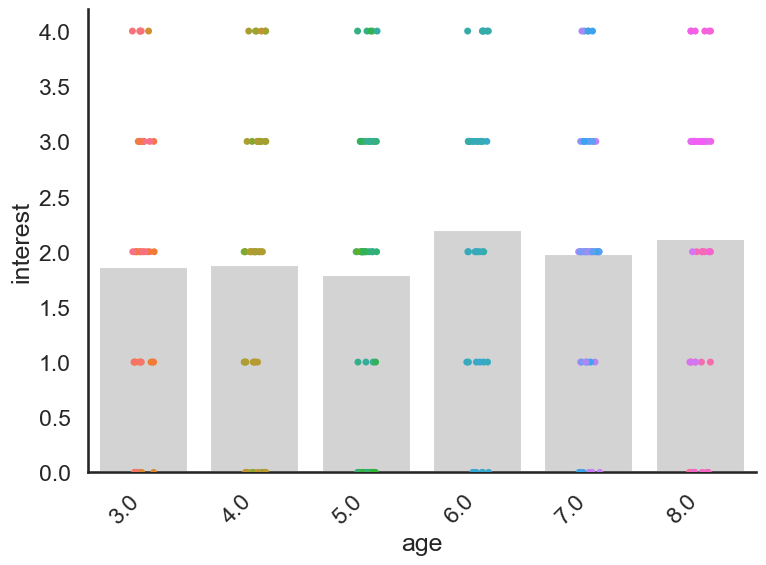

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

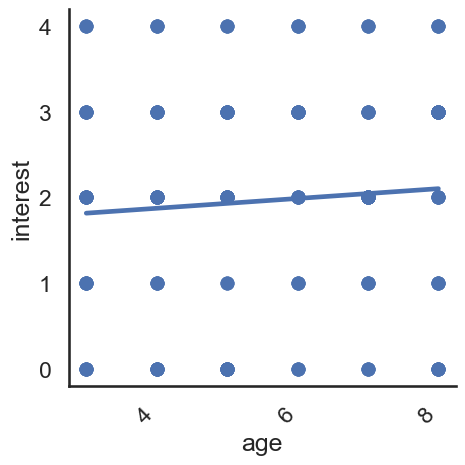

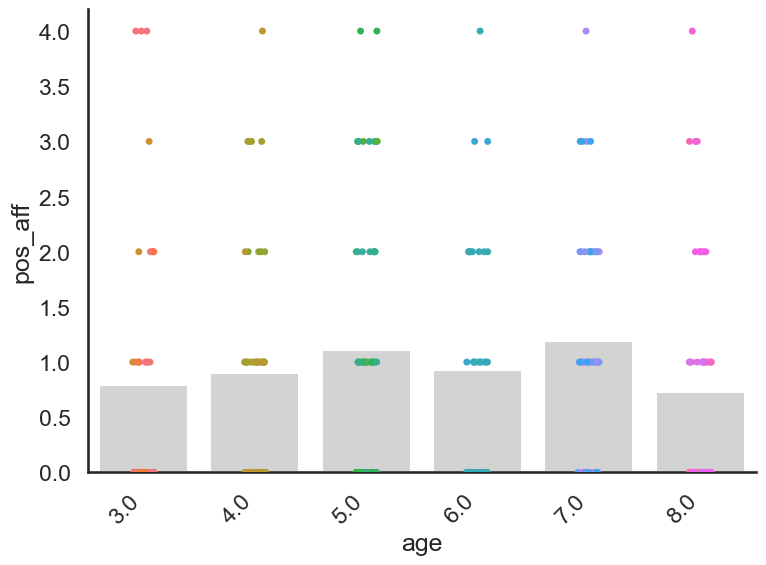

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

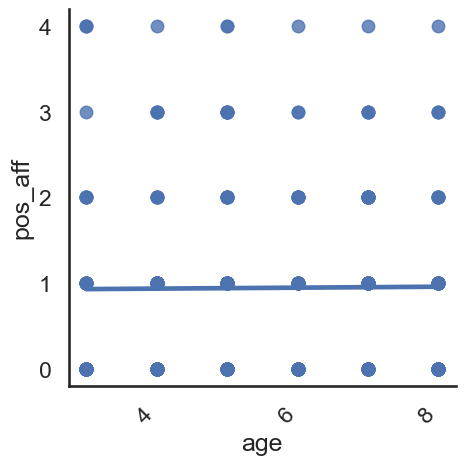

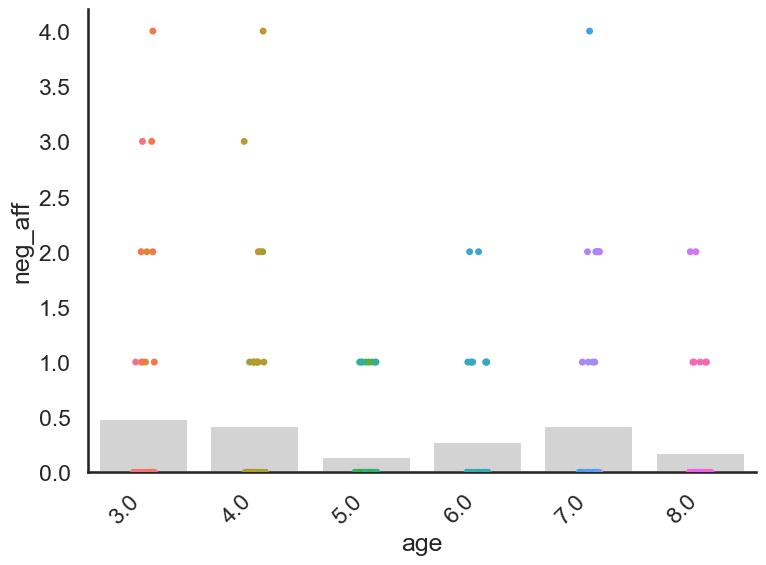

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

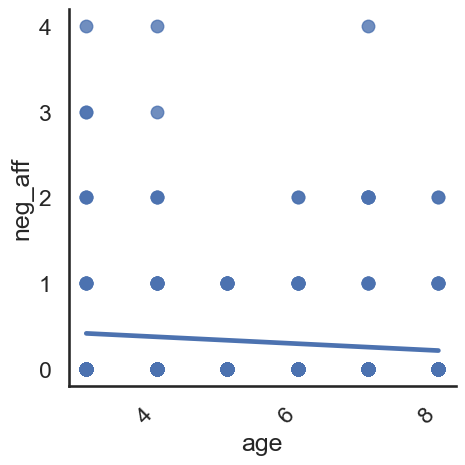

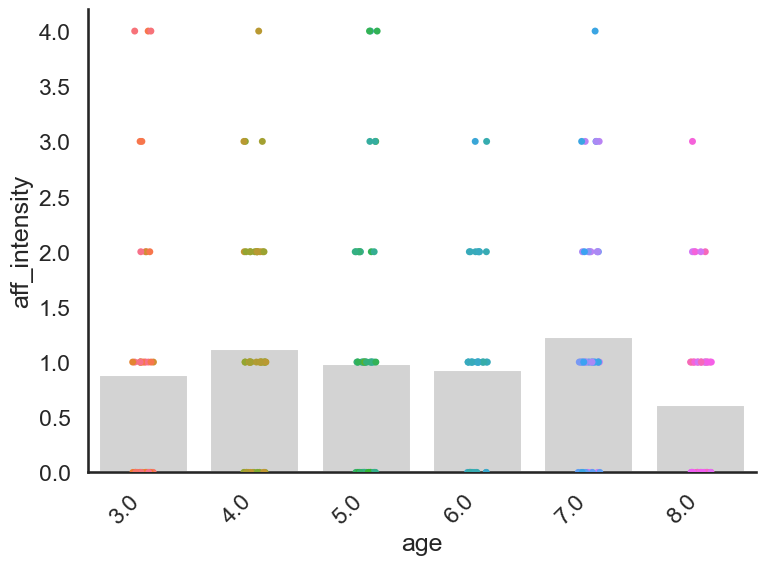

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

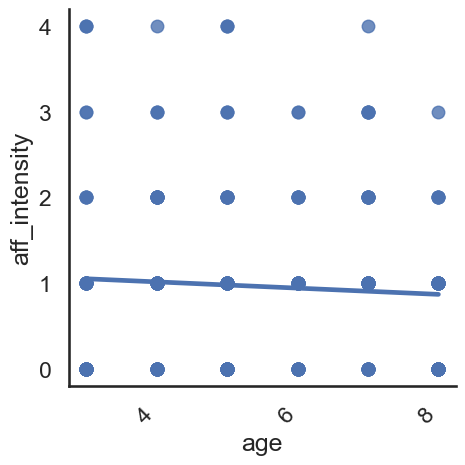

In [28]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v,x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(8,6))
    sns.lmplot(y=v,x='age', data=data, scatter=True, ci=None)
    #sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_lineplot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()


################### interest - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7490   
Min. group size:  2       Log-Likelihood:     -423.1577
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.931    0.153 12.641 0.000  1.632  2.231
human         0.030    0.124  0.243 0.808 -0.213  0.274
sub Var       0.927    0.265                           



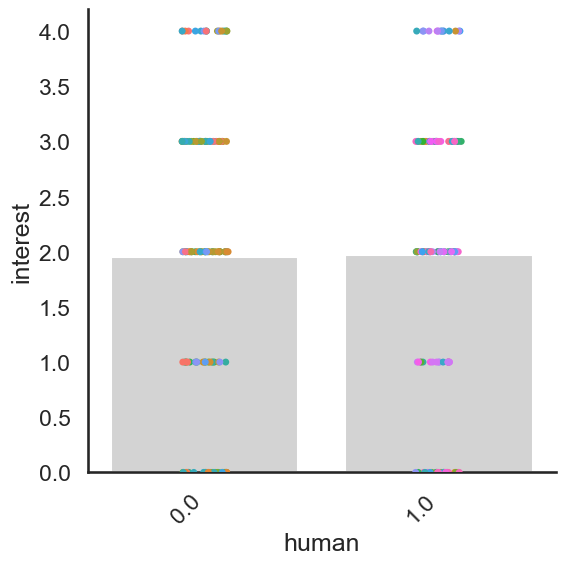


################### interest - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7447   
Min. group size:  2       Log-Likelihood:     -422.6538
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.022    0.155 13.053 0.000  1.718  2.326
speaking     -0.126    0.110 -1.145 0.252 -0.341  0.090
sub Var       0.930    0.266                           



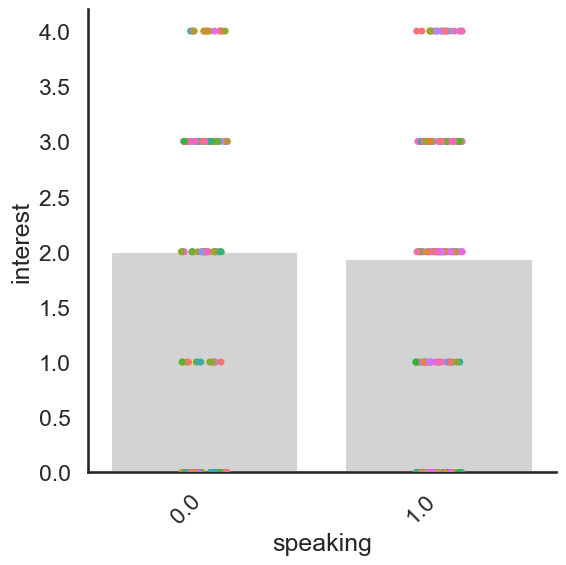


################### interest - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7465   
Min. group size:  2       Log-Likelihood:     -422.8819
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.871    0.169 11.045 0.000  1.539  2.202
contained     0.098    0.123  0.796 0.426 -0.143  0.339
sub Var       0.932    0.267                           



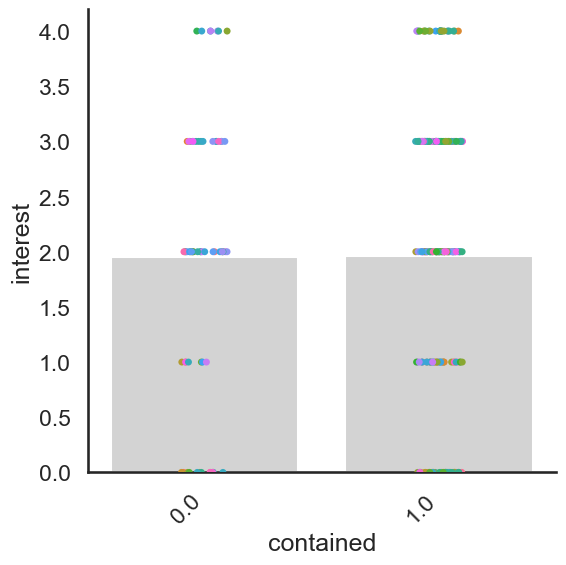


################### pos_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7770   
Min. group size:  2       Log-Likelihood:     -410.2533
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.028    0.118  8.705 0.000  0.797  1.260
human        -0.125    0.122 -1.019 0.308 -0.364  0.115
sub Var       0.415    0.142                           



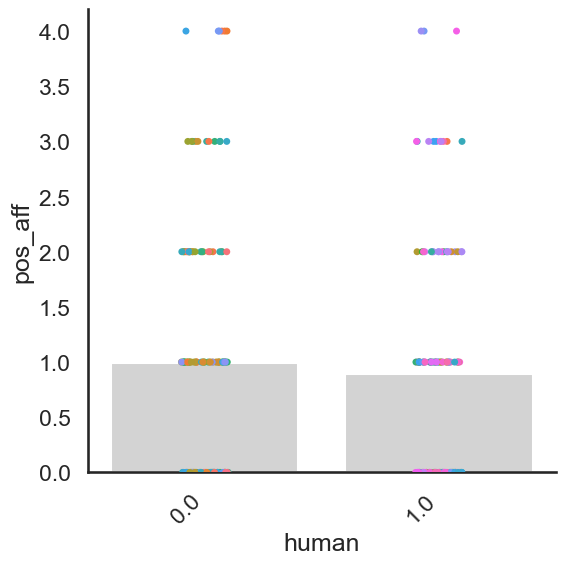


################### pos_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7804   
Min. group size:  2       Log-Likelihood:     -410.7525
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.999    0.122  8.198 0.000  0.760  1.238
speaking     -0.053    0.112 -0.471 0.637 -0.271  0.166
sub Var       0.412    0.141                           



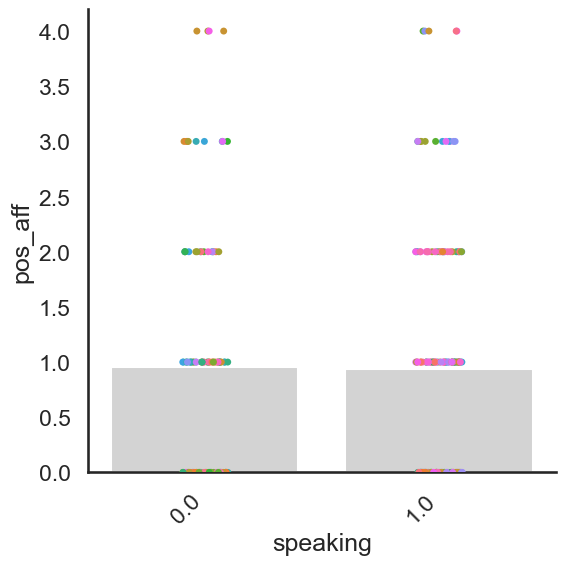


################### pos_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.7758   
Min. group size:  2       Log-Likelihood:     -410.0195
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.850     0.140  6.068  0.000   0.576   1.125
contained  0.151     0.125  1.209  0.227  -0.094   0.396
sub Var    0.414     0.142                              



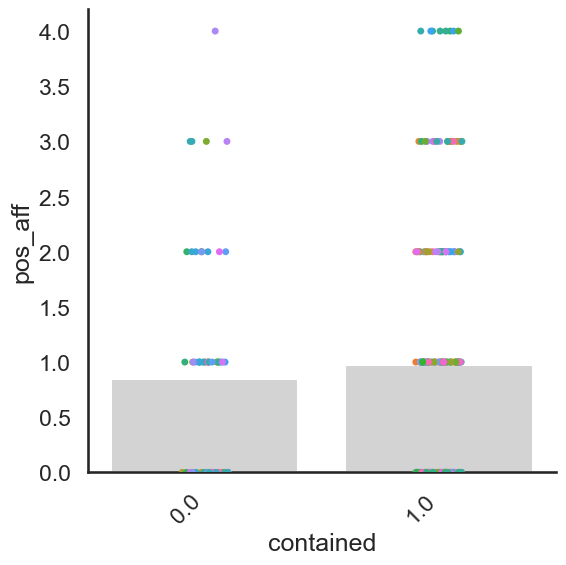


################### neg_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.3306   
Min. group size:  2       Log-Likelihood:     -288.1073
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.228     0.077  2.955  0.003   0.077   0.379
human      0.158     0.080  1.987  0.047   0.002   0.314
sub Var    0.177     0.088                              



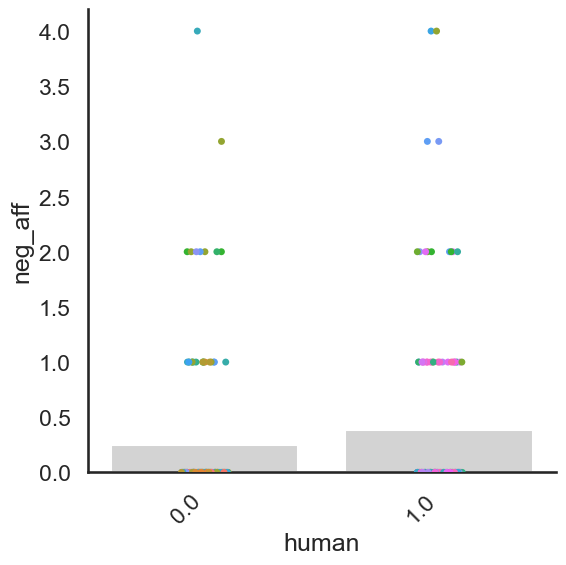


################### neg_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.3350   
Min. group size:  2       Log-Likelihood:     -289.5721
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.353    0.079  4.445 0.000  0.198  0.509
speaking     -0.079    0.073 -1.083 0.279 -0.222  0.064
sub Var       0.174    0.087                           



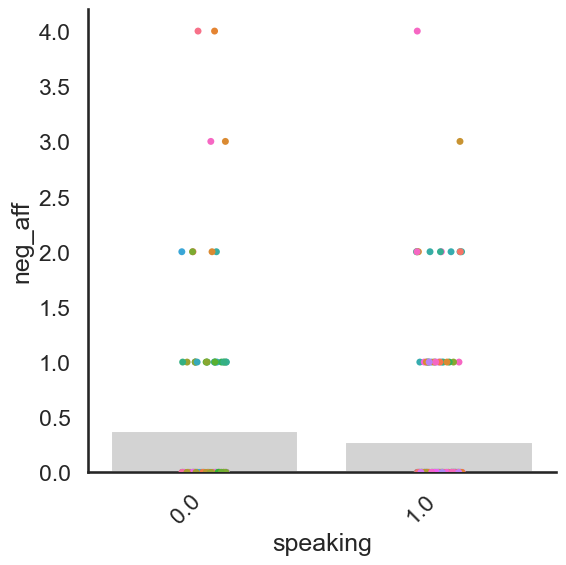


################### neg_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              0.3356   
Min. group size:  2       Log-Likelihood:     -289.8379
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.346    0.092  3.768 0.000  0.166  0.526
contained    -0.053    0.082 -0.639 0.523 -0.214  0.109
sub Var       0.176    0.087                           



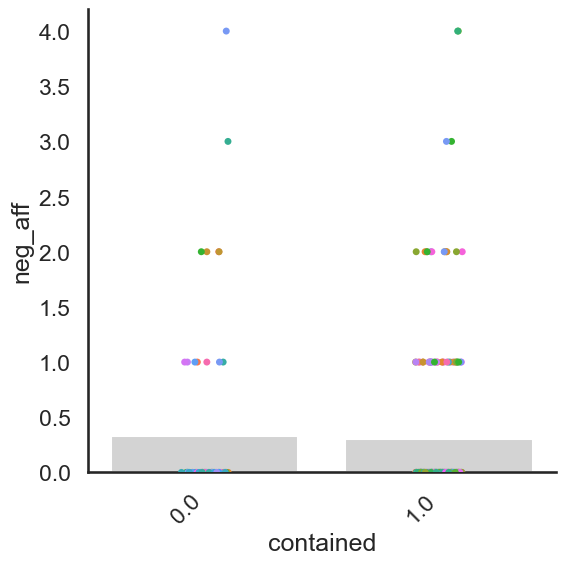


################### aff_intensity - human ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 288     Method:             REML         
No. Groups:       55      Scale:              0.5875       
Min. group size:  2       Log-Likelihood:     -377.5121    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     1.003     0.114   8.775  0.000   0.779   1.227
human        -0.054     0.108  -0.497  0.619  -0.265   0.158
sub Var       0.446     0.158                               



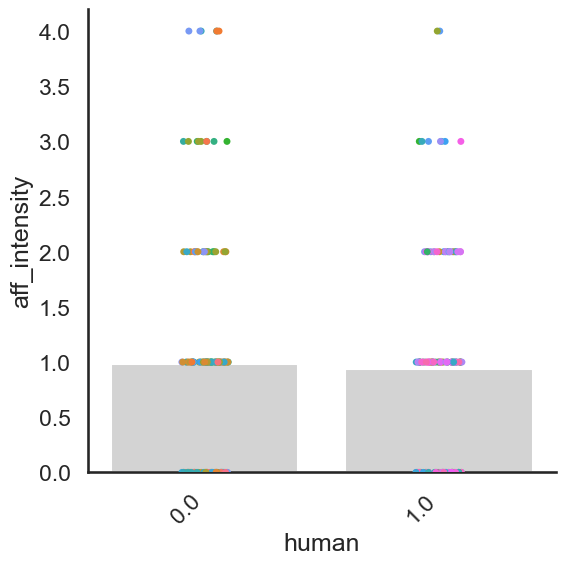


################### aff_intensity - speaking ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 288     Method:             REML         
No. Groups:       55      Scale:              0.5748       
Min. group size:  2       Log-Likelihood:     -375.2081    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     1.108     0.117   9.483  0.000   0.879   1.337
speaking     -0.218     0.096  -2.265  0.024  -0.406  -0.029
sub Var       0.451     0.160                               



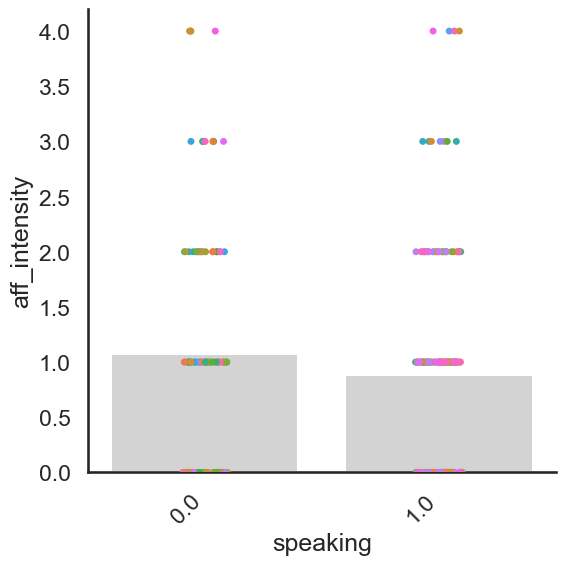


################### aff_intensity - contained ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 288     Method:             REML         
No. Groups:       55      Scale:              0.5803       
Min. group size:  2       Log-Likelihood:     -376.0566    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.828     0.131  6.308  0.000   0.571   1.085
contained      0.192     0.108  1.779  0.075  -0.020   0.404
sub Var        0.447     0.159                              



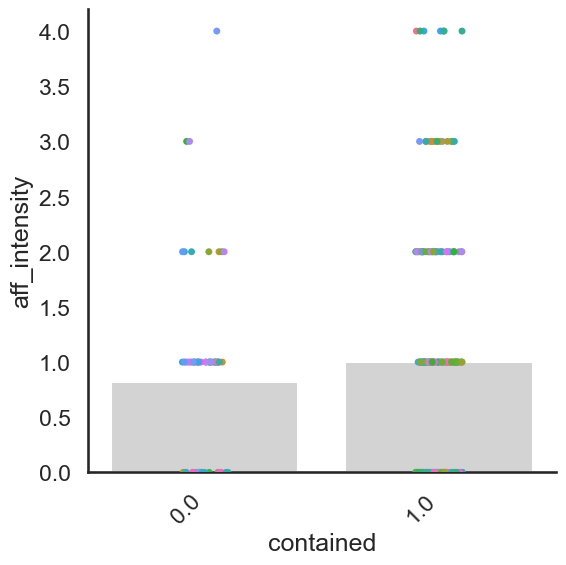

In [29]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1}'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.barplot(y=v,x=f, data=data, color='lightgray', errwidth=0)
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_affect_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()